# Figure 3, S3-6: "Reference" glacier calibration: TI-model & calibration performance

## 1. Comparison between MB model options
## 2. Comparison between calibration options 

This notebook produces plots to show
- Performance of different MB models & calibration options
    - Fig. 3
    - Fig. S3, S4, S5, S6

Calibration was done in the script: `./00_data_creating_scripts/03_cluster_ref_glacier_create_validation_data_MB_ablation_gradient.ipynb` and `./00_data_creating_scripts/02_merging_calibration_options.ipynb`

additional validation data for MB ablation gradients created via the `./00_data_creating_scripts/03_cluster_ref_glacier_create_validation_data_MB_ablation_gradient.ipynb` notebook!

----

In [ ]:
# figure path
fig_path = '/home/users/lschuster/Schuster_et_al_phd_paper_1_cluster/figures'
# data path -> data created from 00_data_creating scripts
data_path = '/home/users/lschuster/Schuster_et_al_phd_paper_1_cluster/01_data'

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', size=20)
import warnings
warnings.filterwarnings("once", category=DeprecationWarning)  # noqa: E402
import scipy
# imports from OGGM
import oggm
from oggm import utils, workflow, tasks, cfg, entity_task
from MBsandbox.mbmod_daily_oneflowline import (TIModel_Sfc_Type, process_w5e5_data)
from MBsandbox.wip.projections_bayescalibration import process_isimip_data, process_isimip_data_no_corr
from MBsandbox.help_func import (minimize_winter_mb_brentq_geod_via_pf, minimize_bias_geodetic,
                                 calibrate_to_geodetic_bias_winter_mb)
from MBsandbox.mbmod_daily_oneflowline import compile_fixed_geometry_mass_balance_TIModel
import time
import logging

log = logging.getLogger(__name__)
num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)'}


## 1. Comparison between TI-model options

1.1 Supplementary Fig. / Analysis of glaciers that can be calibrated for each option : 

In [5]:
pd_params_stats_n = pd.read_csv(f'{data_path}/0_pd_params_stats_not_working_for_all.csv', index_col =0)
calib_types = pd_params_stats_n.calib_type.unique()
pd_params_stats_working_glac_dict = {}
working_rgis_common_dict = {}
len_working_l_dict = {}
for calib_type in calib_types:
    pd_params_stats = pd_params_stats_n.loc[pd_params_stats_n.calib_type == calib_type].copy()

    pd_params_stats = pd_params_stats.loc[(pd_params_stats.sfc_type == 'linear\nmonthly') | (pd_params_stats.sfc_type == 'False') | 
                                          (pd_params_stats.sfc_type == 'neg_exp\nmonthly_t1yr')]
    # only for poster did not want pseudo_daily
    # pd_params_stats = pd_params_stats.loc[pd_params_stats.mb_type != 'mb_pseudo_daily']

    ref_working_l = []
    len_working_l_dict[calib_type] = []
    melt_f_change_l = []
    #grad_type_l = []
    mb_type_l = []
    pd_working_check = pd_params_stats.copy() #loc[pd_params_stats.calib_type==]
    for grad_type in ['cte', 'var_an_cycle']:
        pd_working_check_grad =  pd_working_check.loc[pd_working_check.grad_type ==grad_type]
        for mb_type in ['mb_monthly', #'mb_pseudo_daily',
                        'mb_pseudo_daily_fake', 'mb_real_daily']:
            pd_working_check_mb_type =  pd_working_check_grad.loc[pd_working_check_grad.mb_type ==mb_type]
            for melt_f_change in ['False', 'neg_exp\nmonthly_t1yr', 'linear\nmonthly']:
                pd_working_check_single = pd_working_check_mb_type.loc[pd_working_check_mb_type.sfc_type ==melt_f_change]
                r = pd_working_check_single.index.unique()
                len_working_l_dict[calib_type].append(len(r))
                #grad_type_l.append(grad_type)
                if grad_type == 'var_an_cycle':
                    grad_type_b = ', variable'
                else:
                    grad_type_b = ', constant'
                if mb_type =='mb_real_daily':
                    mb_type_b = 'daily'
                elif mb_type == 'mb_pseudo_daily_fake':
                    mb_type_b = mb_type[3:-5]
                    mb_type_b = 'pseudo-daily'
                else:
                    mb_type_b = mb_type[3:]

                
                mb_type_l.append(mb_type_b+grad_type_b)
                melt_f_change_l.append(melt_f_change)
                ref_working_l.append(r)
                #print(f'{grad_type}, {mb_type}, {melt_f_change[:6]}: n={len(r)}')
    working_rgis_common_dict[calib_type] = ref_working_l[0]
    for j,k in enumerate(ref_working_l[1:]):
        working_rgis_common_dict[calib_type] = list(set(working_rgis_common_dict[calib_type]).intersection(ref_working_l[j]))
    pd_params_stats_working_glac_dict[calib_type] = pd_params_stats.copy() #.loc[working_rgis_common] 

amount of glaciers where calibration worked (with temp. b = 0 & calibration option C_4):
            melt_f_change temporal_resolution_lapse_rate working_glaciers
1   neg_exp\nmonthly_t1yr              monthly, constant              219
2         linear\nmonthly              monthly, constant              219
0                   False              monthly, constant              221
7   neg_exp\nmonthly_t1yr                daily, constant              224
5         linear\nmonthly         pseudo-daily, constant              225
8         linear\nmonthly                daily, constant              225
4   neg_exp\nmonthly_t1yr         pseudo-daily, constant              225
6                   False                daily, constant              226
11        linear\nmonthly              monthly, variable              228
3                   False         pseudo-daily, constant              229
10  neg_exp\nmonthly_t1yr              monthly, variable              229
9                   Fal

/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/local/sw/python/3.10.5/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/local/sw/python/3.10.5/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


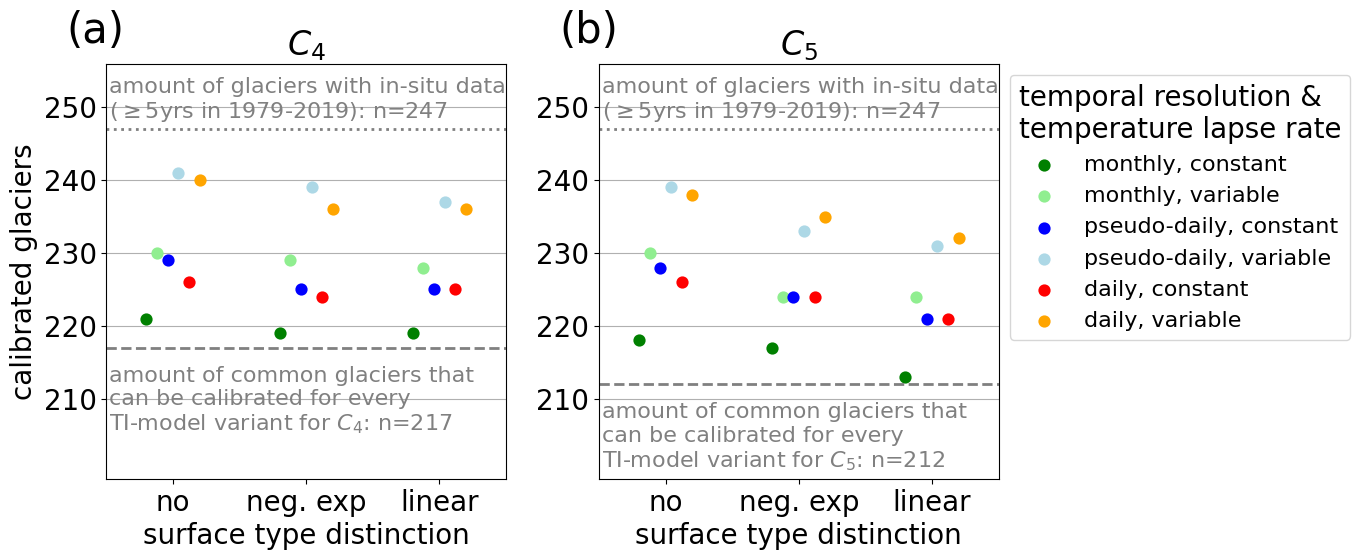

In [6]:
plt.figure(figsize=(14,6))

#####

plt.subplot(121)
plt.gca().text(-0.1,1.05, '(a)', fontsize=30, transform=plt.gca().transAxes)

calib_type = calib_types[-2]

pd_working_glac = pd_params_stats_working_glac_dict[calib_type] 
working_rgis_common = working_rgis_common_dict[calib_type]
print('amount of glaciers where calibration worked (with temp. b = 0 & calibration option C_4):')

dodge=0.4
hue_order = ['monthly, constant', 'monthly, variable', 'pseudo-daily, constant',
             'pseudo-daily, variable', 'daily, constant', 'daily, variable']
col_pal = sns.color_palette(['green','lightgreen','blue','lightblue','red', 'orange'])
pd_working_glac = pd.DataFrame([melt_f_change_l,mb_type_l,len_working_l_dict[calib_type]]).T
pd_working_glac.columns = ['melt_f_change', 'temporal_resolution_lapse_rate', 'working_glaciers' ]
g=sns.pointplot(y='working_glaciers', hue='temporal_resolution_lapse_rate', x='melt_f_change', data=pd_working_glac,
                hue_order=hue_order, palette=col_pal, dodge=dodge, markers='o', join=False) #, ax = axs[j],)
leg = g.get_legend()
leg.remove()
plt.axhline(len(pd_params_stats_n.index.unique()), ls=':', lw=2, color='grey')
plt.text(-0.48, len(pd_params_stats_n.index.unique()) +1.5,
         f'amount of glaciers with in-situ data\n('+r'$\geq$5yrs in 1979-2019)'+f': n={len(pd_params_stats_n.index.unique())}',
         fontsize=16, color = 'grey')
plt.axhline(len(working_rgis_common), ls='--', lw=2, color='grey')
plt.text(-0.48, len(working_rgis_common)-11.4,
         f'amount of common glaciers that\ncan be calibrated for every\nTI-model variant '+ r'for $C_4$'+f': n={len(working_rgis_common)}',
         fontsize=16, color = 'grey')
plt.ylim([199,256])
plt.ylabel(r'calibrated glaciers')
plt.xlabel('surface type distinction')
plt.gca().set_xticklabels(['no', 'neg. exp', 'linear'])
plt.yticks([210,220,230,240,250])
plt.title('$C_4$')

#plt.legend(title='temporal resolution &\ntemperature lapse rate', fontsize=16, bbox_to_anchor=(1,1))
plt.tight_layout()
plt.grid(axis='y')
ax_c4 = plt.gca()
print(pd_working_glac.sort_values(by='working_glaciers'))


########
plt.subplot(122, sharey=ax_c4)
plt.gca().text(-0.1,1.05, '(b)', fontsize=30, transform=plt.gca().transAxes)

calib_type = 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb'
pd_working_glac = pd_params_stats_working_glac_dict[calib_type] 
working_rgis_common = working_rgis_common_dict[calib_type]
print('amount of glaciers where calibration worked (with temp. b = 0 & calibration option e):')

dodge=0.4
hue_order = ['monthly, constant', 'monthly, variable', 'pseudo-daily, constant',
             'pseudo-daily, variable', 'daily, constant', 'daily, variable']
col_pal = sns.color_palette(['green','lightgreen','blue','lightblue','red', 'orange'])
pd_working_glac = pd.DataFrame([melt_f_change_l,mb_type_l,len_working_l_dict[calib_type]]).T
pd_working_glac.columns = ['melt_f_change', 'temporal_resolution_lapse_rate', 'working_glaciers' ]
print(pd_working_glac)
g=sns.pointplot(y='working_glaciers', hue='temporal_resolution_lapse_rate', x='melt_f_change', data=pd_working_glac,
                hue_order=hue_order, palette=col_pal, dodge=dodge, markers='o', join=False) #, ax = axs[j],)
leg = g.get_legend()
leg.remove()
plt.axhline(len(pd_params_stats_n.index.unique()), ls=':', lw=2, color='grey')
plt.text(-0.48, len(pd_params_stats_n.index.unique()) +1.5,
         f'amount of glaciers with in-situ data\n('+r'$\geq$5yrs in 1979-2019)'+f': n={len(pd_params_stats_n.index.unique())}',
         fontsize=16, color = 'grey')
plt.axhline(len(working_rgis_common), ls='--', lw=2, color='grey')
plt.text(-0.48, len(working_rgis_common)-11.4,
         f'amount of common glaciers that\ncan be calibrated for every\nTI-model variant '+ r'for $C_5$'+f': n={len(working_rgis_common)}',
         fontsize=16, color = 'grey')
plt.ylim([199,256])
plt.ylabel('')

plt.xlabel('surface type distinction')
plt.gca().set_xticklabels(['no', 'neg. exp', 'linear'])
plt.yticks([210,220,230,240,250])
plt.legend(title='temporal resolution &\ntemperature lapse rate', fontsize=16, bbox_to_anchor=(1,1))
plt.tight_layout()
plt.title('$C_5$')
plt.grid(axis='y')

plt.savefig(f'{fig_path}/figures_supplements/fig_S3_glacier_amount_possible_to_calibrate_TI_models_C4_C5_w_fake_pseudo_daily.pdf')


- plot below not inside of manuscript of supplements:

amount of glaciers where calibration worked (with temp. b = 0 & calibration option ):
amount of glaciers where calibration worked (with temp. b = 0 & calibration option ):
amount of glaciers where calibration worked (with temp. b = 0 & calibration option ):


/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/local/sw/python/3.10.5/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/local/sw/python/3.10.5/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils 

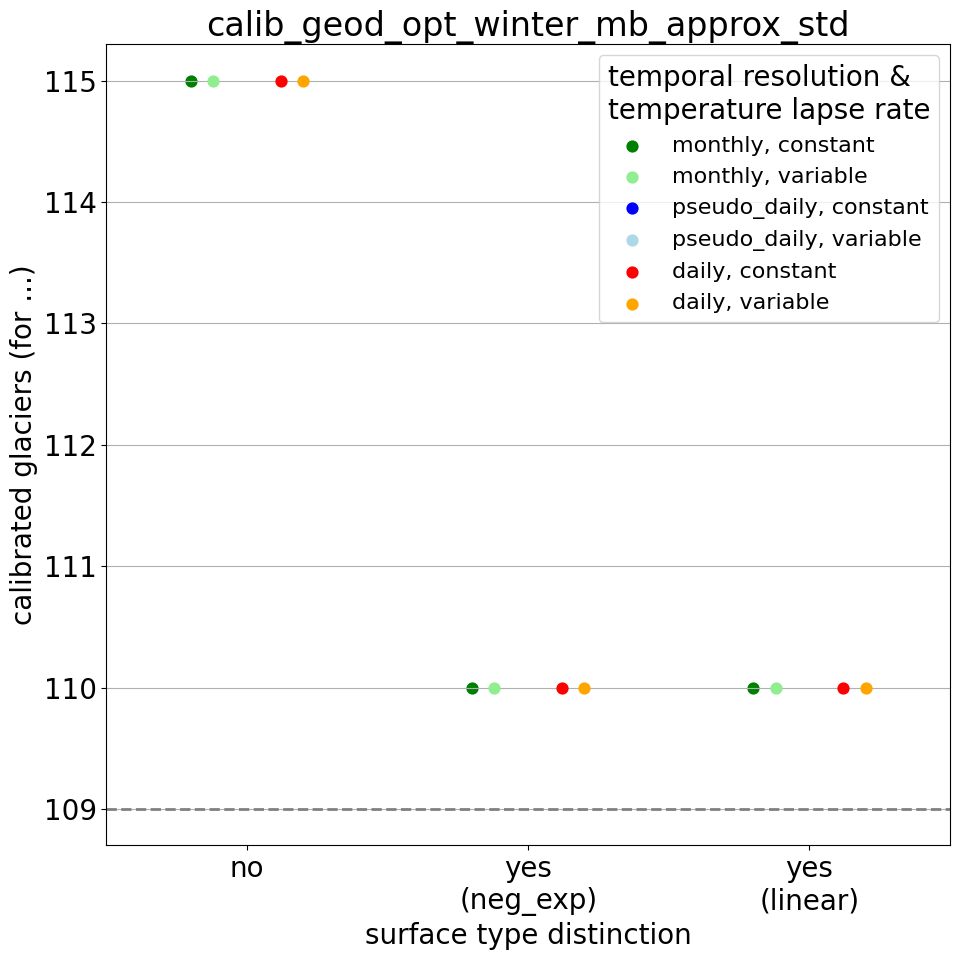

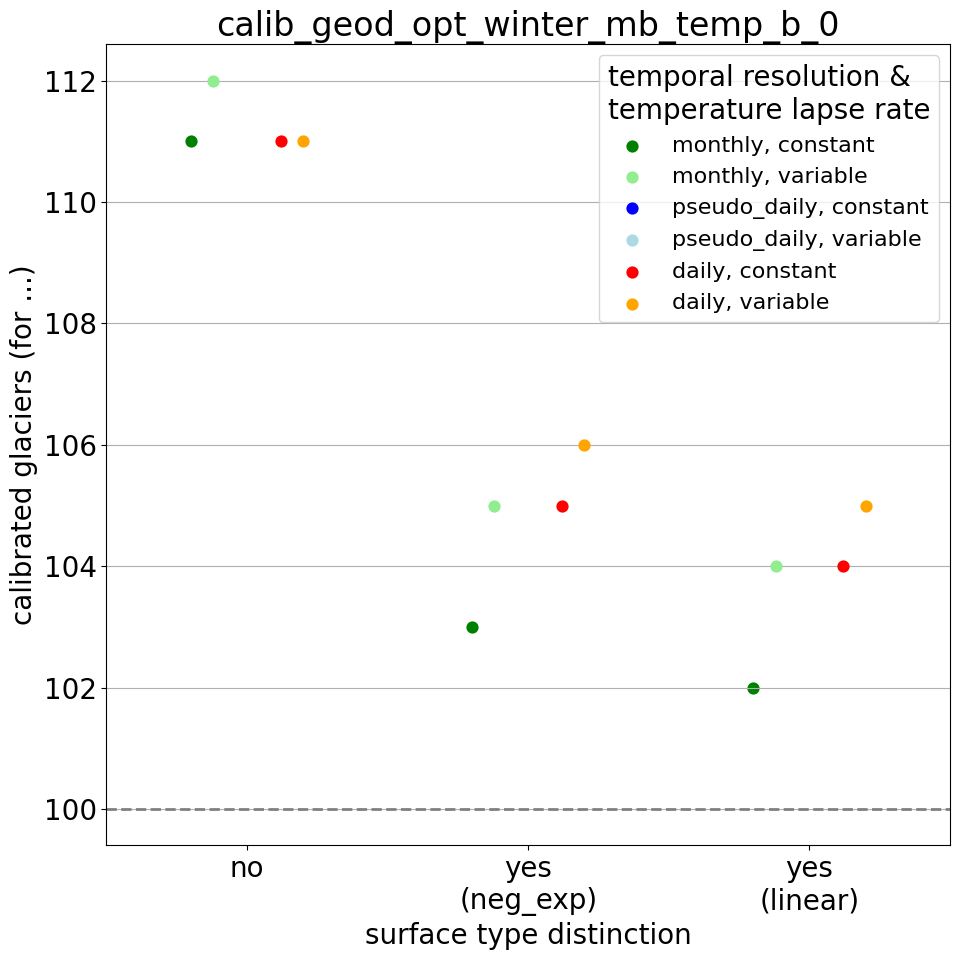

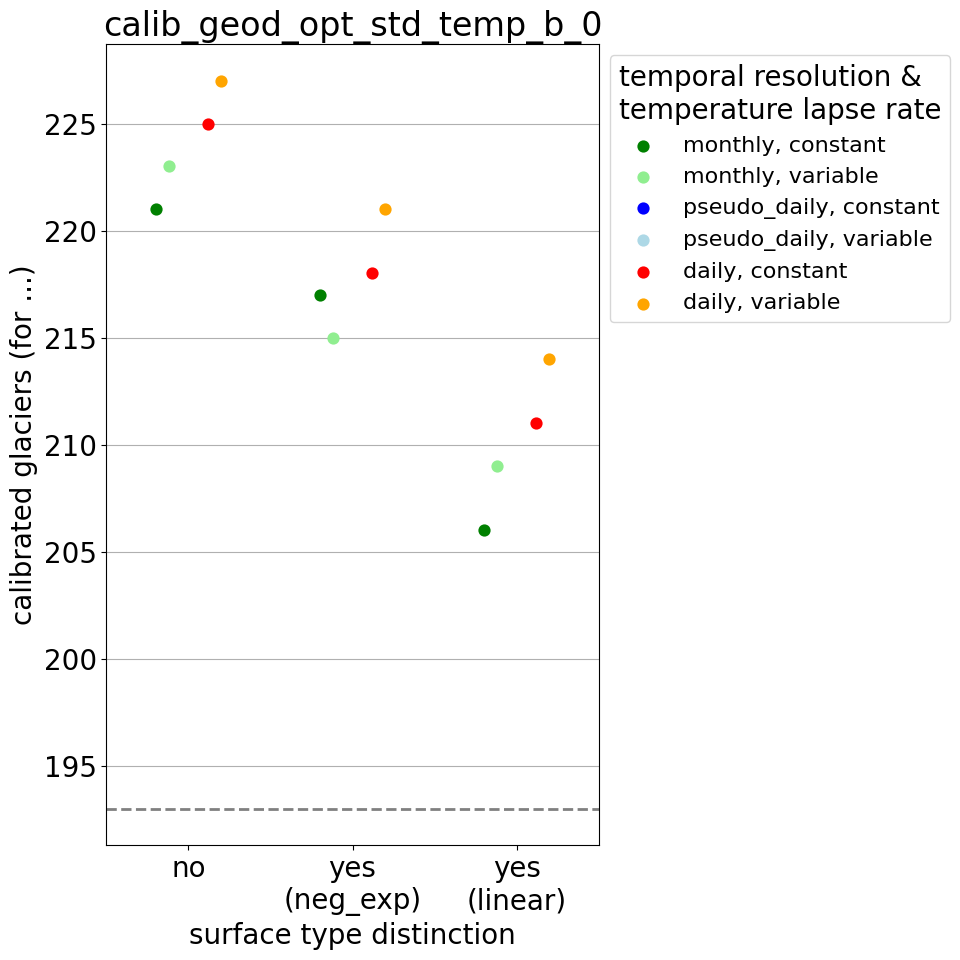

In [7]:
calib_type = calib_types[1]
for calib_type in calib_types[:3]:
    pd_working_glac = pd_params_stats_working_glac_dict[calib_type] 
    working_rgis_common = working_rgis_common_dict[calib_type]
    print('amount of glaciers where calibration worked (with temp. b = 0 & calibration option ):')

    dodge=0.4
    plt.figure(figsize=(10,10))
    plt.title(calib_type)
    hue_order = ['monthly, constant', 'monthly, variable', 'pseudo_daily, constant', 'pseudo_daily, variable', 'daily, constant', 'daily, variable']
    col_pal = sns.color_palette(['green','lightgreen','blue','lightblue','red', 'orange'])
    pd_working_glac = pd.DataFrame([melt_f_change_l,mb_type_l,len_working_l_dict[calib_type]]).T
    pd_working_glac.columns = ['melt_f_change', 'temporal_resolution_lapse_rate', 'working_glaciers' ]
    g=sns.pointplot(y='working_glaciers', hue='temporal_resolution_lapse_rate', x='melt_f_change', data=pd_working_glac,
                    hue_order=hue_order, palette=col_pal, dodge=dodge, markers='o', join=False) #, ax = axs[j],)
    leg = g.get_legend()
    leg.remove()
    #plt.axhline(len(pd_params_stats_n.index.unique()), ls=':', lw=2, color='grey')
    #plt.text(-0.4, len(pd_params_stats_n.index.unique()) +1.5,
    #         f'amount of glaciers with in-situ data\n('+r'$\geq$5yrs in 1979-2019)'+f': n={len(pd_params_stats_n.index.unique())}',
    #         fontsize=16, color = 'grey')
    plt.axhline(len(working_rgis_common), ls='--', lw=2, color='grey')
    #plt.text(-0.4, len(working_rgis_common)-11.4,
    #         f'amount of common glaciers that can be\ncalibrated for every TI-model variant\n'+ r'for ...'+f': n={len(working_rgis_common)}',
    #         fontsize=16, color = 'grey')
    #plt.ylim([199,256])
    plt.ylabel(r'calibrated glaciers (for ...)')
    plt.xlabel('surface type distinction')
    plt.gca().set_xticklabels(['no', 'yes\n(neg_exp)', 'yes\n(linear)'])
    #plt.yticks([210,220,230,240,250])
    plt.legend(title='temporal resolution &\ntemperature lapse rate', fontsize=16, bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.grid(axis='y')
    #plt.savefig(f'{fig_path}/supplements/glacier_amount_possible_to_calibrate_TI_models_{calib_type}.pdf')
    #pd_working_glac.sort_values(by='working_glaciers')
    pd_working_glac.sort_values(by='working_glaciers')

#### 1.2 **Performance analysis: MB mae, ablation gradient & std. quotient measure**

**MB profile match analysis for different TI-models**

- **Suppl. Fig. subplot a: by looking at mean absolute error to MB profile:** (changed the order, and first look at MB ablation gradient)

In [8]:
calib_type = 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb'
working_rgis_common = working_rgis_common_dict[calib_type]

pd_params_stats_w_for_calib_option_e = pd_params_stats_working_glac_dict[calib_type].loc[working_rgis_common] 


In [9]:
pd_params_stats_w_for_calib_option_e = pd_params_stats_w_for_calib_option_e.loc[pd_params_stats_w_for_calib_option_e['mae_mb_profile'].dropna().index]

In [10]:
pd_c = pd_params_stats_w_for_calib_option_e.reset_index().groupby('rgi_id.1').count()
assert np.where(pd_c['rgi_id']==576)


In [11]:
xr_params_stats_w_for_calib_option_e = pd_params_stats_w_for_calib_option_e.groupby(['mb_type','grad_type', 'rgi_id', 'sfc_type', 'calib_type']).mean().to_xarray()
# we only selected this calib option already futher up in the code, but just to be sure: 
xr_params_stats_w_for_calib_option_e = xr_params_stats_w_for_calib_option_e.sel(calib_type = calib_type)


mae_mb_profile_ratio_vs_def = xr_params_stats_w_for_calib_option_e[['mae_mb_profile']] / xr_params_stats_w_for_calib_option_e.sel(grad_type=['cte'],
                                                                                                                mb_type = ['mb_monthly'], 
                                                                                                                sfc_type=['False']).mae_mb_profile.values
pd_mae_mb_profile_ratio_vs_def = mae_mb_profile_ratio_vs_def.to_dataframe().reset_index().dropna()

In [12]:
# precipitation factor for HEF  (necessary for the bucket plot example plot of the supplements, used in  
# http://localhost:8889/lab/tree/Schreibtisch/PhD/Schuster_et_al_phd_paper_1/analysis_notebooks/updated_2022_10_notebooks/figure_oggm_sfc_type_snow_ageing_bucket_and_explanations.ipynb!!!)
xr_params_stats_w_for_calib_option_e.sel(rgi_id='RGI60-11.00897').pf_opt

<xarray.DataArray 'pf_opt' (mb_type: 4, grad_type: 2, sfc_type: 3)>
array([[[3.47737432, 3.47737432, 3.47737432],
        [3.47737432, 3.47737432, 3.47737432]],

       [[3.47737432, 3.47737432, 3.47737432],
        [3.47737432, 3.47737432, 3.47737432]],

       [[3.47737432, 3.47737432, 3.47737432],
        [3.47737432, 3.47737432, 3.47737432]],

       [[3.47737432, 3.47737432, 3.47737432],
        [3.47737432, 3.47737432, 3.47737432]]])
Coordinates:
  * mb_type     (mb_type) object 'mb_monthly' ... 'mb_real_daily'
  * grad_type   (grad_type) object 'cte' 'var_an_cycle'
    rgi_id      <U14 'RGI60-11.00897'
  * sfc_type    (sfc_type) object 'False' ... 'neg_exp\nmonthly_t1yr'
    calib_type  <U45 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb'

In [13]:
default_mae_mb_profile = xr_params_stats_w_for_calib_option_e.sel(grad_type=['cte'], mb_type = ['mb_monthly'], sfc_type=['False']).mae_mb_profile.values.flatten()
default_mae_mb_profile = default_mae_mb_profile[~np.isnan(default_mae_mb_profile)]
default_mae_mb_profile_q = np.quantile(default_mae_mb_profile, q=[0.025, 0.25,0.5,0.75,0.975])
print(default_mae_mb_profile_q)

[ 151.1128523   344.86623594  556.24844503  820.07491727 1951.07143112]


/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/local/sw/python/3.10.5/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/local/sw/python/3.10.5/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Versi

n=83 glaciers with
MB profile data used


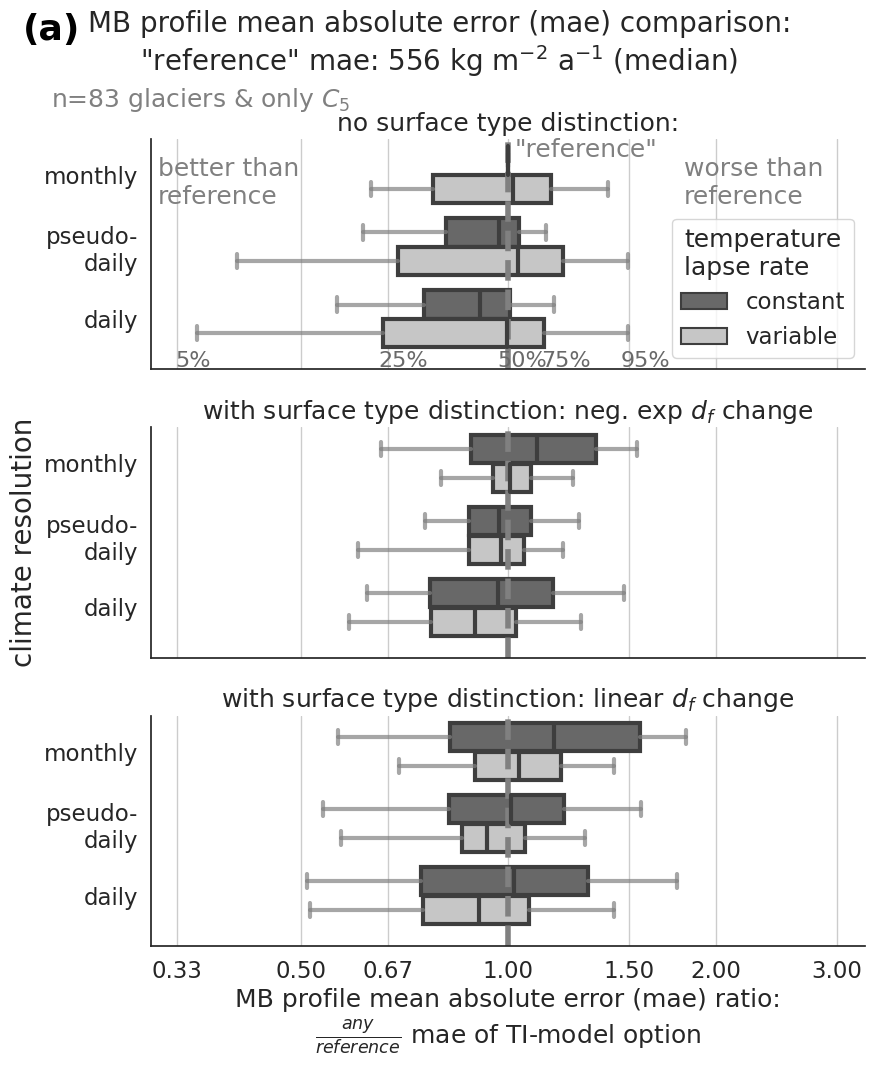

In [14]:
### plot for MB models mae MB profile ratio
pd_mae_mb_profile_ratio_vs_def = pd_mae_mb_profile_ratio_vs_def.loc[(pd_mae_mb_profile_ratio_vs_def.mb_type!='mb_pseudo_daily')]
pd_mae_mb_profile_ratio_models_sel = pd_mae_mb_profile_ratio_vs_def
#pd_mae_mb_profile_ratio_models_sel = pd_mae_mb_profile_ratio_models_sel.loc[pd_mae_mb_profile_ratio_models_sel.mb_type != 'mb_pseudo_daily']
#pd_mae_mb_profile_ratio_models_sel = pd_mae_mb_profile_ratio_models_sel.loc[pd_mae_mb_profile_ratio_models_sel.sfc_type != 'neg_exp\nmonthly_t1yr']

len_mb_profile_working = len(pd_mae_mb_profile_ratio_models_sel.rgi_id.unique())

#ds_spread['volume'] = np.abs(ds_spread.volume-1) #ds_spread.volume.
sns.set(font_scale=1.5)
sns.set_style('white')

#plt.figure(figsize=(18,10))
#ax = plt.gca()
#ax.text(1.3, 0.3, f'n={len_mb_profile_working} glaciers with MB profile\ndata used. ')
#plt.suptitle(f'n={len_mb_profile_working} glaciers with MB profile\ndata used')
f= sns.catplot(y='mb_type', x='mae_mb_profile', hue='grad_type', row='sfc_type',
               data=pd_mae_mb_profile_ratio_models_sel,
               palette='Greys_r',
               row_order = ['False', 'neg_exp\nmonthly_t1yr', 'linear\nmonthly'],
                              order=['mb_monthly', 'mb_pseudo_daily_fake', 'mb_real_daily'],
                              hue_order=['cte', 'var_an_cycle'],
                kind='box',
                fliersize=0, 
               legend_out=False,
               height=3.65,
                linewidth=3, aspect=2.5,
                saturation=0.7, #ax=ax,
               whis = [5,95], 
                    capprops={'color':'grey', 'alpha':0.7},
                    whiskerprops={'color':'grey', 'alpha':0.7}
               ) #, grid=True)
print(f'n={len_mb_profile_working} glaciers with\nMB profile data used')

#f.axes[0][0].text(-0.2, 1.15, f'(a)', color='black', fontsize=24, transform=f.axes[0][0].transAxes)

ax = plt.gca()
# f.axes[0][0].text(0.35, -0.25, f'n={len_mb_profile_working} glaciers with\nMB profile data used', color='gray')
f.axes[0][0].text(1.02, -0.25, f'"reference"', color='gray')
f.axes[0][0].text(0.31, 0.4, f'better than\nreference', color = 'grey')
f.axes[0][0].text(1.8, 0.4, f'worse than\nreference', color = 'grey')

f.axes[0][0].set_yticklabels(['monthly', 'pseudo-\ndaily','daily'])
f.axes[0][0].set_ylabel('')
leg = f.axes[0][0].legend()
leg2 = f.axes[0][0].legend(leg.get_patches()[:2], ['constant', 'variable'], title='temperature\nlapse rate',
                           loc = 'lower right')
leg.remove()
f.axes[0][0].add_artist(leg2)
f.axes[0][0].axvline(1, lw=4, ls='--', color = 'grey')

f.axes[0][0].set_title('no surface type distinction:')

f.axes[1][0].set_yticklabels(['monthly', 'pseudo-\ndaily', 'daily'])
f.axes[1][0].set_ylabel('climate resolution', fontsize=20)
f.axes[1][0].axvline(1, lw=4, ls='--', color = 'grey')
f.axes[1][0].set_title('with surface type distinction: neg. exp $d_f$ change')

#plt.grid()

f.axes[0][0].set_xscale("log")
f.axes[1][0].set_xscale("log")
f.axes[2][0].set_xscale("log")

from matplotlib.ticker import ScalarFormatter, NullFormatter
for axis in [f.axes[0][0], f.axes[1][0], f.axes[2][0]]:
    axis.xaxis.set_major_formatter(ScalarFormatter())
    axis.xaxis.set_minor_formatter(NullFormatter())
f.axes[0][0].set_xlim([0.303,3.3])
f.axes[1][0].set_xlim([0.303,3.3])
f.axes[2][0].set_xlim([0.303,3.3])
#f.axes[2][0].set_xticklabels([])


f.axes[0][0].set_xticks([0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0]) #, labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
f.axes[1][0].set_xticks([0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0]) # , labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
f.axes[2][0].set_xticks([0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0]) #, labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])


f.axes[2][0].grid(axis='x')
f.axes[1][0].grid(axis='x')
f.axes[0][0].grid(axis='x')

f.axes[2][0].set_yticklabels(['monthly', 'pseudo-\ndaily', 'daily'])
f.axes[2][0].set_ylabel('')
f.axes[2][0].axvline(1, lw=4, ls='--', color = 'grey')
f.axes[2][0].set_title(r'with surface type distinction: linear $d_f$ change')


pd_qs_legend = pd_mae_mb_profile_ratio_models_sel.loc[(pd_mae_mb_profile_ratio_models_sel.sfc_type=='False') 
                                                      & (pd_mae_mb_profile_ratio_models_sel.grad_type=='var_an_cycle') &
                                      (pd_mae_mb_profile_ratio_models_sel.mb_type=='mb_real_daily')]
qs = pd_qs_legend.mae_mb_profile.quantile([0.05,0.25,0.5,0.75,0.95]).values
#ax.text(qs[0]-14,-0.42,f'percentiles:', color = 'dimgrey', fontsize=15)

for p,q in enumerate(qs):
    perci = [5,25,50,75,95][p]
    if perci == 5:
        f.axes[0][0].text(q-0.01,+2.67,f'{perci}%', color = 'dimgrey', fontsize=16)
    elif perci == 50:
        f.axes[0][0].text(q-0.03,+2.67,f'{perci}%', color = 'dimgrey', fontsize=16)
    elif perci == 95:
        f.axes[0][0].text(q-0.06,+2.67,f'{perci}%', color = 'dimgrey', fontsize=16)
    else:
        f.axes[0][0].text(q-0.01,+2.67,f'{perci}%', color = 'dimgrey', fontsize=16)


f.axes[0][0].set_ylim([2.7, -0.5])

f.axes[2][0].set_xlabel('MB profile mean absolute error (mae) ratio:\n'+r'$\frac{any}{reference}$ mae of TI-model option', fontsize=18)

plt.suptitle('MB profile mean absolute error (mae) comparison:\n'
             +f'"reference" mae: {default_mae_mb_profile_q[2]:.0f} '+r'kg m$^{-2}$ a$^{-1}$ (median)',
             fontsize=20)
plt.tight_layout()

f.axes[0][0].text(-0.18, 1.43, f'(a)', color='black', fontsize=26, transform=f.axes[0][0].transAxes,weight='bold')
f.axes[0][0].text(-0.14, 1.14, f'n={len_mb_profile_working} glaciers & only '+r'$C_5$', color='grey', fontsize=18, transform=f.axes[0][0].transAxes)

plt.savefig(f'{fig_path}/figures_supplements/fig_S5_a_ti_model_performance_calib_option_e_mae_mb_profile_ratio_subplotb_w_fake_pseudo_daily.pdf')
#plt.savefig(f'{fig_path}/ti_model_performance_calib_option_e_mae_mb_profile_ratio_subplotb.pdf')


**subplot b: Ablation gradient difference...**
**todo: add statistics about ablation gradient heree**


In [18]:
#pd_params_stats_not_w_f_all = pd.read_csv(f'/home/lilianschuster/Schreibtisch/PhD/Schuster_et_al_phd_paper_1/data/pd_params_stats_not_working_for_all.csv')
pd_stats_mb_ablation_grad_ti_model_comparison = pd.read_csv(f'{data_path}/0_pd_stats_mb_ablation_grad_ti_model_comparison.csv',
                                                            index_col=0)
pd_stats_mb_ablation_grad_ti_model_comparison['abs_difference_mod_vs_obs_abl_grad'] = np.absolute(pd_stats_mb_ablation_grad_ti_model_comparison['difference_mod_vs_obs_abl_grad']).values

xr_params_stats_w_for_calib_option_e_mb_abl_grad = pd_stats_mb_ablation_grad_ti_model_comparison.groupby(['mb_type','grad_type', 'rgi_id',
                                                                                                          'sfc_type', 'calib_type']).mean().to_xarray()
# we only selected this calib option already futher up in the code, but just to be sure: 
xr_params_stats_w_for_calib_option_e_mb_abl_grad = xr_params_stats_w_for_calib_option_e_mb_abl_grad.sel(calib_type = calib_type)
mb_ablation_grad_match_diff_ratio_vs_def = xr_params_stats_w_for_calib_option_e_mb_abl_grad[['abs_difference_mod_vs_obs_abl_grad']] - xr_params_stats_w_for_calib_option_e_mb_abl_grad.sel(grad_type=['cte'],
                                                                                                                mb_type = ['mb_monthly'], 
                                                                                                                sfc_type=['False']).abs_difference_mod_vs_obs_abl_grad.values
pd_mb_ablation_grad_match_diff_vs_def = mb_ablation_grad_match_diff_ratio_vs_def.to_dataframe().reset_index().dropna()

In [19]:
default_mb_abl_grad_diff = xr_params_stats_w_for_calib_option_e_mb_abl_grad.sel(grad_type=['cte'], mb_type = ['mb_monthly'], sfc_type=['False']).abs_difference_mod_vs_obs_abl_grad.values.flatten()
default_mb_abl_grad_diff = default_mb_abl_grad_diff[~np.isnan(default_mb_abl_grad_diff)]
default_mb_abl_grad_diff_q = np.quantile(default_mb_abl_grad_diff, q=[0.025, 0.25,0.5,0.75,0.975])

In [20]:
pd_mb_ablation_grad_match_diff_vs_def

,mb_type,grad_type,rgi_id,sfc_type,calib_type,abs_difference_mod_vs_obs_abl_grad
0,mb_monthly,cte,RGI60-02.00296,False,calib_only_geod_temp_b_0_pf_fit_via_winter_mb,0.000000
1,mb_monthly,cte,RGI60-02.00296,linear,calib_only_geod_temp_b_0_pf_fit_via_winter_mb,-3.065916
2,mb_monthly,cte,RGI60-02.00296,neg_exp,calib_only_geod_temp_b_0_pf_fit_via_winter_mb,-1.489783
3,mb_monthly,cte,RGI60-02.00377,False,calib_only_geod_temp_b_0_pf_fit_via_winter_mb,0.000000
4,mb_monthly,cte,RGI60-02.00377,linear,calib_only_geod_temp_b_0_pf_fit_via_winter_mb,1.199726
...,...,...,...,...,...,...
1915,mb_real_daily,var_an_cycle,RGI60-16.02086,linear,calib_only_geod_temp_b_0_pf_fit_via_winter_mb,3.008719
1916,mb_real_daily,var_an_cycle,RGI60-16.02086,neg_exp,calib_only_geod_temp_b_0_pf_fit_via_winter_mb,3.033255
1917,mb_real_daily,var_an_cycle,RGI60-16.02444,False,calib_only_geod_temp_b_0_pf_fit_via_winter_mb,5.065056
1918,mb_real_daily,var_an_cycle,RGI60-16.02444,linear,calib_only_geod_temp_b_0_pf_fit_via_winter_mb,3.599878


In [21]:
pd_mb_ablation_grad_match_diff_vs_def.mb_type.unique()

array(['mb_monthly', 'mb_pseudo_daily', 'mb_pseudo_daily_fake',
       'mb_real_daily'], dtype=object)

/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/local/sw/python/3.10.5/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/local/sw/python/3.10.5/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


n=80 glaciers with MB abl. gradient 
data used. 


/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/local/sw/python/3.10.5/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/local/sw/python/3.10.5/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Ver

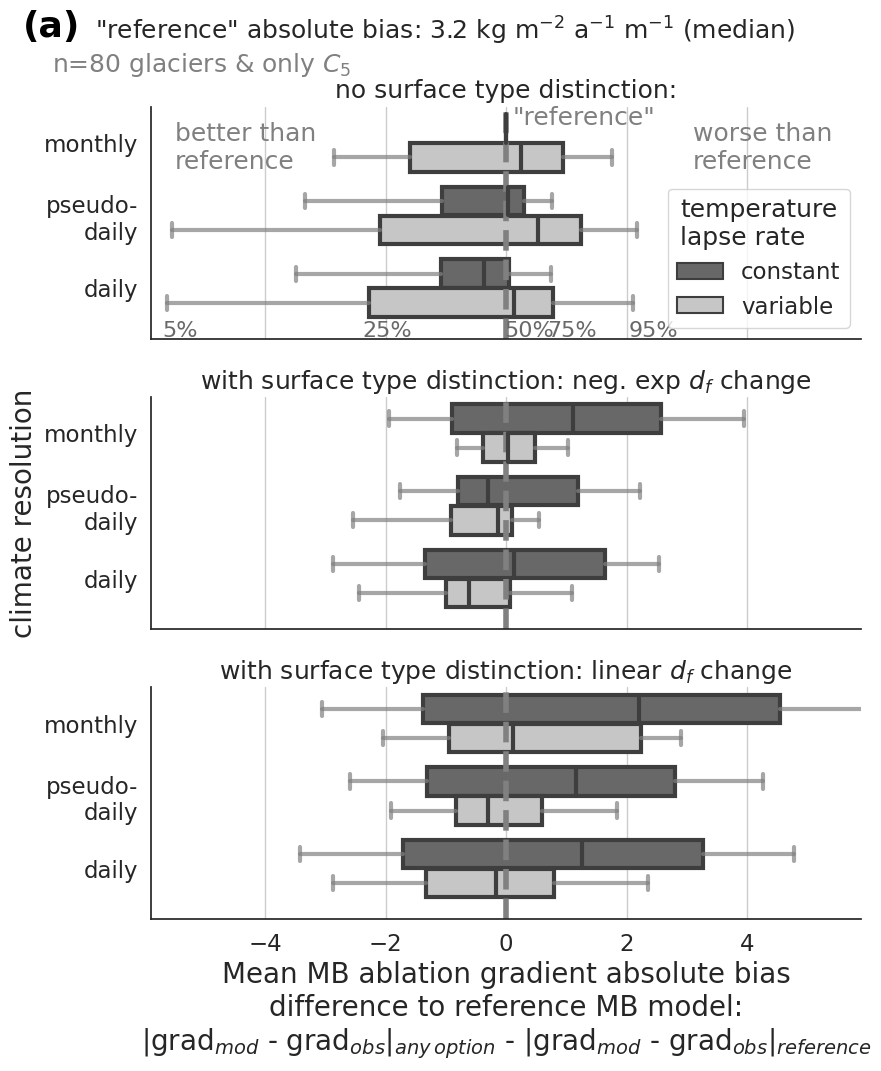

In [22]:
#pd_std_quot_abs_diff_to_1_vs_def_sel = pd_std_quot_abs_diff_to_1_vs_def_sel.loc[pd_std_quot_abs_diff_to_1_vs_def_sel.mb_type != 'mb_pseudo_daily']
#pd_std_quot_abs_diff_to_1_vs_def_sel = pd_std_quot_abs_diff_to_1_vs_def_sel.loc[pd_std_quot_abs_diff_to_1_vs_def_sel.sfc_type != 'neg_exp\nmonthly_t1yr']

len_mb_abl_grad_working = len(pd_mb_ablation_grad_match_diff_vs_def.rgi_id.unique())

#ds_spread['volume'] = np.abs(ds_spread.volume-1) #ds_spread.volume.
sns.set(font_scale=1.5)
sns.set_style('white')
ylabels = ['monthly', 'pseudo-\ndaily',#'pseudo-\ndaily\ncte',
           'daily']
#plt.figure(figsize=(18,10))
#ax = plt.gca()
#ax.text(1.3, 0.3, f'n={len_mb_profile_working} glaciers with MB profile\ndata used. ')
print(f'n={len_mb_abl_grad_working} glaciers with MB abl. gradient \ndata used. ')
f= sns.catplot(y='mb_type', x='abs_difference_mod_vs_obs_abl_grad',
               hue='grad_type', row='sfc_type', data=pd_mb_ablation_grad_match_diff_vs_def,
                              row_order = ['False', 'neg_exp', 'linear'],
               palette='Greys_r',
               hue_order=['cte', 'var_an_cycle'],
               order=['mb_monthly', #'mb_pseudo_daily',
                      'mb_pseudo_daily_fake', 'mb_real_daily'],
                #palette=col_pal_ssp, #
                kind='box',
                fliersize=0, 
               legend_out=False,
               height=3.65,
                linewidth=3, aspect=2.5,
                #col = 'time',
                #order = calib_types, #legend_out=False,
                saturation=0.7, #ax=ax,
               whis = [5,95], 
                    capprops={'color':'grey', 'alpha':0.7},
                    whiskerprops={'color':'grey', 'alpha':0.7}
               ) #, grid=True)

#f.axes[0][0].text(-0.2, 1.05, f'(b)', color='black', fontsize=24, transform=f.axes[0][0].transAxes)

#f.axes[0][0].text(-0.14, 1.18, f'n={len_mb_abl_grad_working} glaciers & only '+r'$C_5$',
#                  color='black', fontsize=18, transform=f.axes[0][0].transAxes)
#plt.suptitle(r'(b)  '+'Comparion of mean absolute MB ablation gradient biases:\n'+f'"default": {default_mb_abl_grad_diff_q[2]:.1f} '+r'kg m$^{-2}$ a$^{-1}$ m$^{-1}$ (median)', fontsize=20)

#f.axes[0][0].text(-0.9, -0.2, f'n={len_std_working} glaciers with\ninterannual variability data used')

ax = plt.gca()
f.axes[0][0].text(0.1, -0.25, f'"reference"', color='gray')
#f.axes[0][0].text(-4.9, 0.63, f'better than reference', color = 'grey')
#f.axes[0][0].text(1.4, 0.63, f'worse than reference', color = 'grey')
f.axes[0][0].text(-5.5, 0.35, f'better than\nreference', color = 'grey')
f.axes[0][0].text(3.1, 0.35, f'worse than\nreference', color = 'grey')

f.axes[0][0].set_yticklabels(ylabels)
f.axes[0][0].set_ylabel('')
leg = f.axes[0][0].legend()
#leg2 = f.axes[0][0].legend(leg.get_patches()[:2], ['constant', 'variable'], title='temperature lapse rate', loc = 'upper right')
leg.remove()
#f.axes[0][0].add_artist(leg2)
f.axes[0][0].axvline(0, lw=4, ls='--', color = 'grey')

f.axes[0][0].set_title('no surface type distinction:')

f.axes[1][0].set_yticklabels(ylabels)
f.axes[1][0].set_ylabel('climate resolution', fontsize=20)
f.axes[1][0].axvline(0, lw=4, ls='--', color = 'grey')
f.axes[1][0].set_title(r'with surface type distinction: neg. exp $d_f$ change')


f.axes[0][0].set_xlim([-5.9,5.9])
f.axes[1][0].set_xlim([-5.9,5.9])
f.axes[2][0].set_xlim([-5.9,5.9])


f.axes[1][0].grid(axis='x')
f.axes[0][0].grid(axis='x')
f.axes[2][0].grid(axis='x')
                  
f.axes[2][0].set_yticklabels(ylabels)
f.axes[2][0].set_ylabel('')
f.axes[2][0].axvline(0, lw=4, ls='--', color = 'grey')
f.axes[2][0].set_title(r'with surface type distinction: linear $d_f$ change')

f.axes[0][0].set_ylim([2.7, -0.5])


f.axes[2][0].set_xlabel(f'Mean MB ablation gradient absolute bias\ndifference to reference MB model:\n'
                        +r'|grad$_{mod}$ - grad$_{obs}$|$_{any\,option}$ - |grad$_{mod}$ - grad$_{obs}$|$_{reference}$', fontsize=20)


pd_qs_legend = pd_mb_ablation_grad_match_diff_vs_def.loc[(pd_mb_ablation_grad_match_diff_vs_def.sfc_type=='False')
                                                         & (pd_mb_ablation_grad_match_diff_vs_def.grad_type=='var_an_cycle') &
                                      (pd_mb_ablation_grad_match_diff_vs_def.mb_type=='mb_real_daily')]
qs = pd_qs_legend.abs_difference_mod_vs_obs_abl_grad.quantile([0.05,0.25,0.5,0.75,0.95]).values
#ax.text(qs[0]-14,-0.42,f'percentiles:', color = 'dimgrey', fontsize=15)

for p,q in enumerate(qs):
    perci = [5,25,50,75,95][p]
    if perci == 5:
        f.axes[0][0].text(q-0.08,+2.67,f'{perci}%', color = 'dimgrey', fontsize=16)
    elif perci == 50:
        f.axes[0][0].text(q-0.16,+2.67,f'{perci}%', color = 'dimgrey', fontsize=16)
    elif perci == 95:
        f.axes[0][0].text(q-0.12,+2.67,f'{perci}%', color = 'dimgrey', fontsize=16)
    else:
        f.axes[0][0].text(q-0.1,+2.67,f'{perci}%', color = 'dimgrey', fontsize=16)

leg = f.axes[0][0].legend()
leg2 = f.axes[0][0].legend(leg.get_patches()[:2], ['constant', 'variable'], title='temperature\nlapse rate',
                           loc = 'lower right')

#plt.suptitle('Comparison of MB profile mean absolute errors (mae):\n'+f'"default" mae: {default_mae_mb_profile_q[2]:.0f} '+r'kg m$^{-2}$ a$^{-1}$ (median)',
#             fontsize=20)
plt.suptitle(#r'$\,$Mean MB ablation gradient absolute bias comparison:'+'\n'
             r'$\,$'+f' "reference" absolute bias: {default_mb_abl_grad_diff_q[2]:.1f} '+r'kg m$^{-2}$ a$^{-1}$ m$^{-1}$ (median)',
             fontsize=18)

plt.tight_layout()

f.axes[0][0].text(-0.18, 1.3, f'(a)', color='black', fontsize=26, transform=f.axes[0][0].transAxes,weight='bold')

#plt.savefig(f'{fig_path}/ti_model_performance_calib_option_e_mb_ablation_grad_match_diff_subplota_all_for_fabi.png')
f.axes[0][0].text(-0.14, 1.15, f'n={len_mb_abl_grad_working} glaciers & only '+r'$C_5$',
                  color='grey', fontsize=18, transform=f.axes[0][0].transAxes)
plt.savefig(f'{fig_path}/fig_3_a_ti_model_performance_calib_option_e_mb_ablation_grad_match_diff_subplota_w_fake_pseudo_daily.pdf')


**subplot c: Std. quotient match plot for MB models** : for difference in absolute difference to perfect standard deviation match:



In [23]:
std_quot_abs_diff_to_1_vs_def = np.abs(xr_params_stats_w_for_calib_option_e[['quot_std']]-1) - np.abs(xr_params_stats_w_for_calib_option_e.sel(grad_type=['cte'],mb_type = ['mb_monthly'],sfc_type=['False']).quot_std.values-1)
pd_std_quot_abs_diff_to_1_vs_def = std_quot_abs_diff_to_1_vs_def.to_dataframe().reset_index().dropna()

In [24]:
default_std_quot = xr_params_stats_w_for_calib_option_e.sel(grad_type=['cte'], mb_type = ['mb_monthly'], sfc_type=['False']).quot_std.values.flatten()
default_std_quot = default_std_quot[~np.isnan(default_std_quot)]
default_std_quot_q = np.quantile(default_std_quot, q=[0.025, 0.25,0.5,0.75,0.975])
print(default_std_quot_q)

[0.49286037 0.74718279 0.99910918 1.63269147 2.79111725]


In [25]:
pd_std_quot_abs_diff_to_1_vs_def.mb_type.unique()

array(['mb_monthly', 'mb_pseudo_daily', 'mb_pseudo_daily_fake',
       'mb_real_daily'], dtype=object)

/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/local/sw/python/3.10.5/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/local/sw/python/3.10.5/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Versi

n=83 glaciers with interannual variability
data used. 


/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):


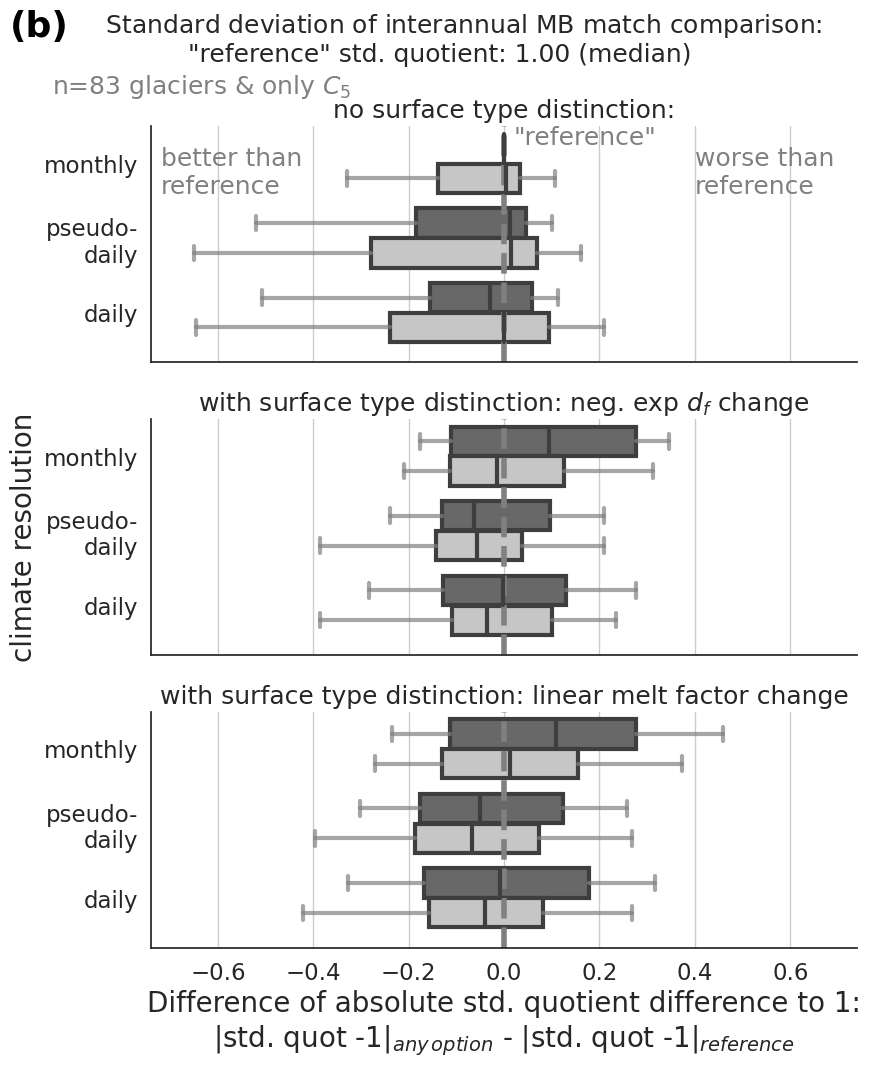

In [27]:
pd_std_quot_abs_diff_to_1_vs_def_sel = pd_std_quot_abs_diff_to_1_vs_def
#pd_std_quot_abs_diff_to_1_vs_def_sel = pd_std_quot_abs_diff_to_1_vs_def_sel.loc[pd_std_quot_abs_diff_to_1_vs_def_sel.mb_type != 'mb_pseudo_daily']
#pd_std_quot_abs_diff_to_1_vs_def_sel = pd_std_quot_abs_diff_to_1_vs_def_sel.loc[pd_std_quot_abs_diff_to_1_vs_def_sel.sfc_type != 'neg_exp\nmonthly_t1yr']

len_std_working = len(pd_std_quot_abs_diff_to_1_vs_def_sel.rgi_id.unique())

#ds_spread['volume'] = np.abs(ds_spread.volume-1) #ds_spread.volume.
sns.set(font_scale=1.5)
sns.set_style('white')

#plt.figure(figsize=(18,10))
#ax = plt.gca()
#ax.text(1.3, 0.3, f'n={len_mb_profile_working} glaciers with MB profile\ndata used. ')
print(f'n={len_std_working} glaciers with interannual variability\ndata used. ')
f= sns.catplot(y='mb_type', x='quot_std', hue='grad_type', row='sfc_type', data=pd_std_quot_abs_diff_to_1_vs_def_sel,
                              row_order = ['False', 'neg_exp\nmonthly_t1yr', 'linear\nmonthly'],
               palette='Greys_r',
               hue_order=['cte', 'var_an_cycle'],
               order=['mb_monthly', 'mb_pseudo_daily_fake', 'mb_real_daily'],
                #palette=col_pal_ssp, #
                kind='box',
                fliersize=0, 
               legend_out=False,
               height=3.65,
                linewidth=3, aspect=2.5,
                #col = 'time',
                #order = calib_types, #legend_out=False,
                saturation=0.7, #ax=ax,
               whis = [5,95], 
                    capprops={'color':'grey', 'alpha':0.7},
                    whiskerprops={'color':'grey', 'alpha':0.7}
               ) #, grid=True)

#f.axes[0][0].text(-0.2, 1.05, f'(c)', color='black', fontsize=24, transform=f.axes[0][0].transAxes)

ax = plt.gca()
f.axes[0][0].text(0.02, -0.25, f'"reference"', color='gray')
#f.axes[0][0].text(-0.9, 0.6, f'better than reference', color = 'grey')
#f.axes[0][0].text(0.25, 0.6, f'worse than reference', color = 'grey')
f.axes[0][0].text(-0.72, 0.4, f'better than\nreference', color = 'grey')
f.axes[0][0].text(0.4, 0.4, f'worse than\nreference', color = 'grey')

f.axes[0][0].set_yticklabels(['monthly', 'pseudo-\ndaily', 'daily'])
f.axes[0][0].set_ylabel('')
leg = f.axes[0][0].legend()
#leg2 = f.axes[0][0].legend(leg.get_patches()[:2], ['constant', 'variable'], title='temperature lapse rate', loc = 'upper right')
leg.remove()
#f.axes[0][0].add_artist(leg2)
f.axes[0][0].axvline(0, lw=4, ls='--', color = 'grey')

f.axes[0][0].set_title('no surface type distinction:')

f.axes[1][0].set_yticklabels(['monthly', 'pseudo-\ndaily', 'daily'])
f.axes[1][0].set_ylabel('climate resolution', fontsize=20)
f.axes[1][0].axvline(0, lw=4, ls='--', color = 'grey')
f.axes[1][0].set_title(r'with surface type distinction: neg. exp $d_f$ change')

f.axes[0][0].set_xlim([-0.74,0.74])
f.axes[1][0].set_xlim([-0.74,0.74])

f.axes[1][0].grid(axis='x')
f.axes[0][0].grid(axis='x')
f.axes[2][0].grid(axis='x')

f.axes[2][0].set_yticklabels(['monthly', 'pseudo-\ndaily', 'daily'])
f.axes[2][0].set_ylabel('')
f.axes[2][0].axvline(0, lw=4, ls='--', color = 'grey')
f.axes[2][0].set_title('with surface type distinction: linear melt factor change')

f.axes[0][0].set_ylim([2.67, -0.5])


f.axes[2][0].set_xlabel(f'Difference of absolute std. quotient difference to 1:\n'
                        +r'|std. quot -1|$_{any\,option}$ - |std. quot -1|$_{reference}$', fontsize=20)

plt.suptitle(r'$\qquad$'+'Standard deviation of interannual MB match comparison:\n'+
             f'"reference" std. quotient: {default_std_quot_q[2]:.2f} '+r'(median)', fontsize=18)
plt.tight_layout()
f.axes[0][0].text(-0.2, 1.38, f'(b)', color='black', fontsize=26, transform=f.axes[0][0].transAxes, weight='bold')
f.axes[0][0].text(-0.14, 1.14, f'n={len_std_working} glaciers & only '+r'$C_5$',
                  color='grey', fontsize=18, transform=f.axes[0][0].transAxes)

plt.savefig(f'{fig_path}/figures_supplements/fig_S5_b_ti_model_performance_calib_option_e_std_match_diff_subplotc_w_pseudo_daily_fake.pdf')


### Supplementary Figure S4:

/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/local/sw/python/3.10.5/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/local/sw/python/3.10.5/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Versi

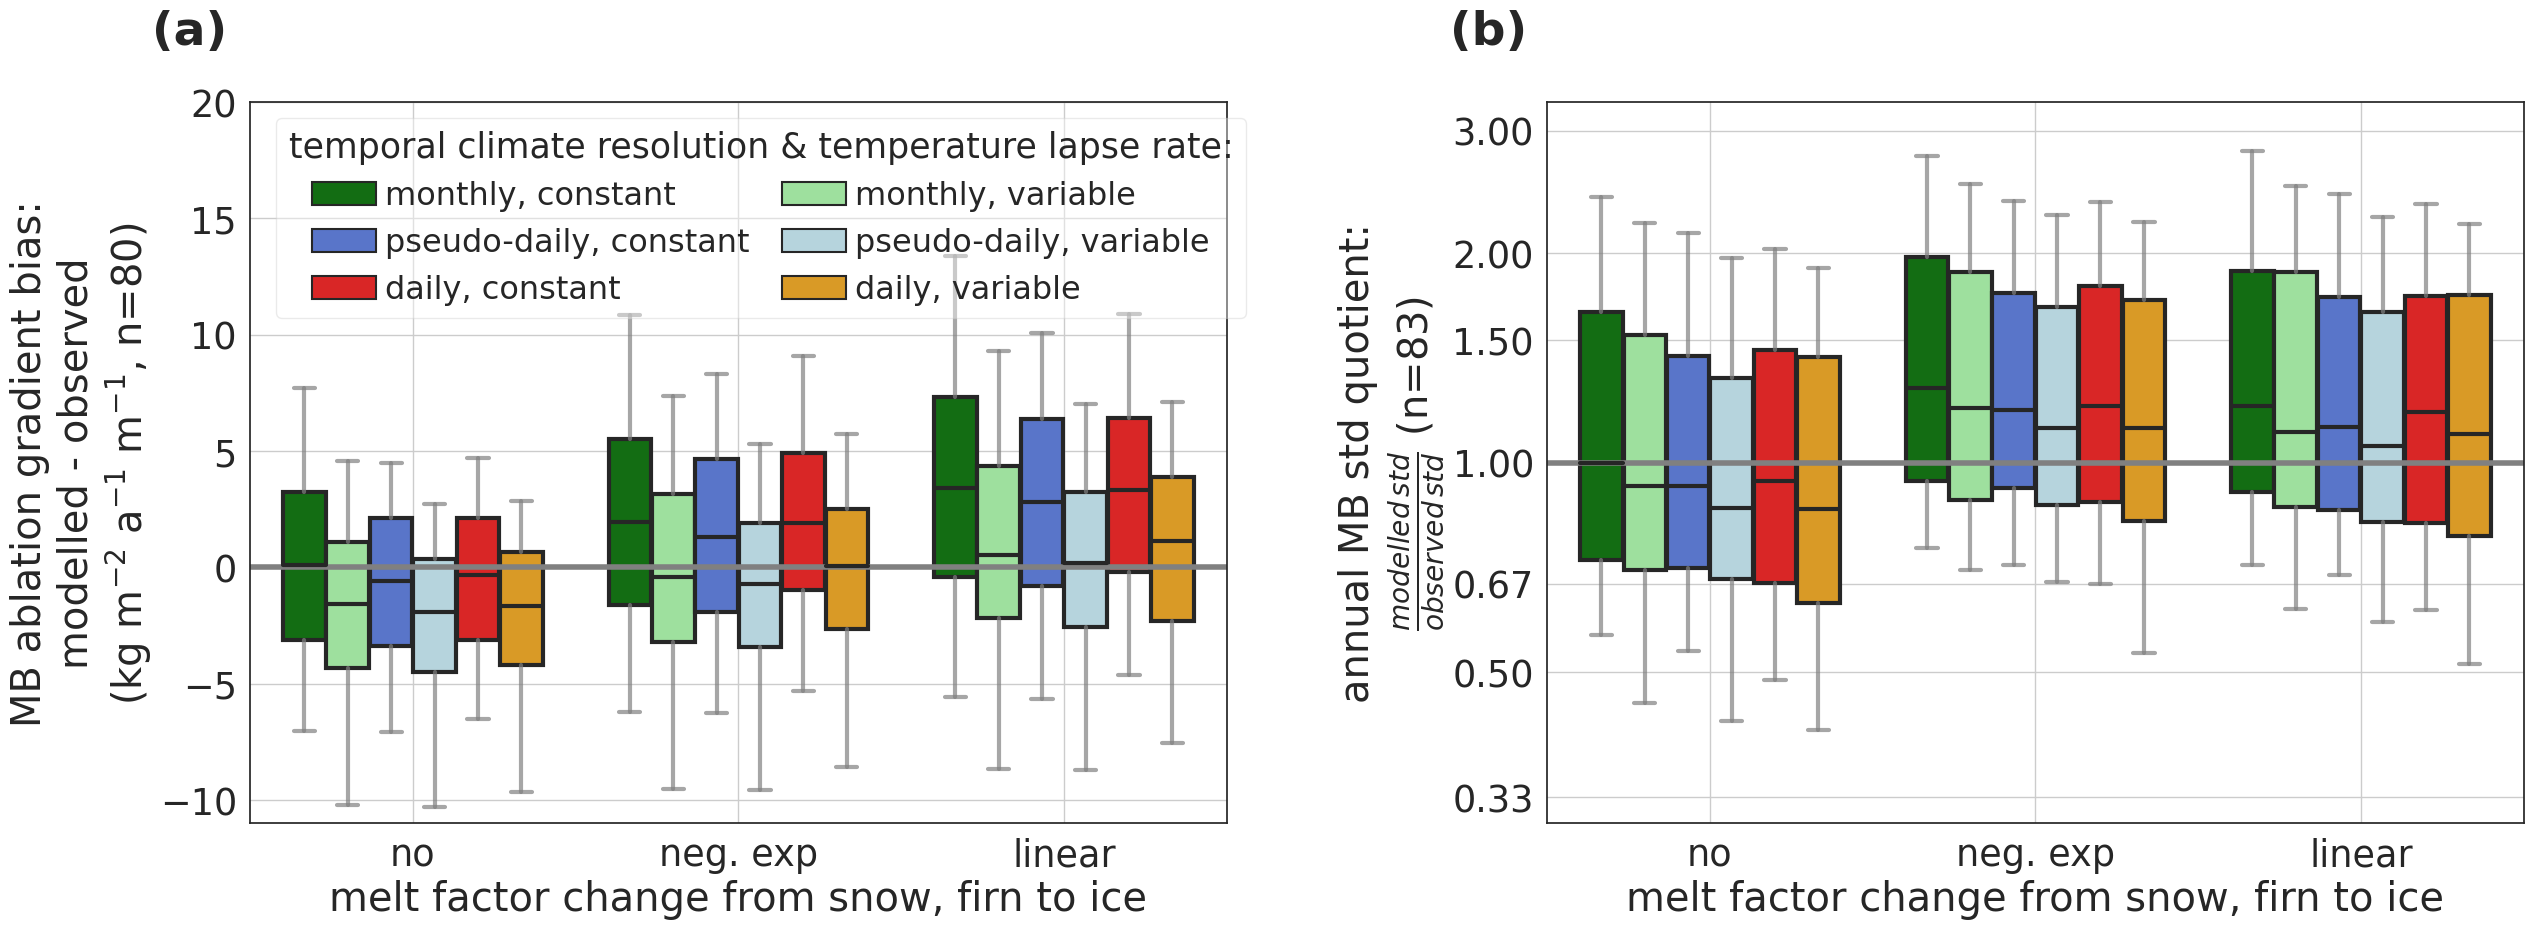

In [28]:
marker = 's'
sns.set(font_scale=2.4)
sns.set_style('white')

col_pal = sns.color_palette(['green','lightgreen','royalblue','lightblue',
                             'red', 'orange'])

hue_order = ['mb_monthly_cte', 'mb_monthly_var_an_cycle',
             'mb_pseudo_daily_fake_cte', 'mb_pseudo_daily_fake_var_an_cycle',
             'mb_real_daily_cte',
       'mb_real_daily_var_an_cycle']

order = ['False', 'neg_exp','linear'  #'linear\nannual',
           #'neg_exp\nmonthly', #'neg_exp\nannual'
            ]
order2 = ['False', 'neg_exp','linear']
          #'neg_exp\nmonthly_t1yr']

j = 0
p=0
fig, axs = plt.subplots(1,2, figsize=(26,10))
for p,param in enumerate(['difference_mod_vs_obs_abl_grad', 'quot_std']): #, 'pf_opt', 'temp_bias']):
    #plt.plot(figsize=(30,20))
    
    axs[p].text(-0.1,1.08, num_dict[p], fontsize=34, transform=axs[p].transAxes,weight='bold')
    if param == 'quot_std':
        pd_tt = pd_params_stats_w_for_calib_option_e.reset_index().copy() #pd_stats_abl_grad_poster
    else:
        pd_tt = pd_stats_mb_ablation_grad_ti_model_comparison #pd_params_stats #.loc[pd_params_stats.calib_type==calib_type]
    if param == 'quot_std':
        inft_glac = pd_tt.loc[pd_tt.quot_std == np.inf]
        #pd_tt = pd_tt.loc[pd_tt.rgi_id != inft_glac.index.unique()[0]]
        #inft_glac = pd_params_stats.loc[pd_params_stats.quot_std == np.inf]
        assert len(inft_glac.index.unique()) == 0
        #pd_tt = pd_tt.loc[pd_tt['rgi_id.1'] != inft_glac.index.unique()[0]]
        
    #pd_tt = pd_tt.loc[(pd_tt.sfc_type != 'neg_exp\nannual_t1yr') & (pd_tt.sfc_type != 'linear\nannual')]
    if True:
        g = sns.boxplot(y=param, data=pd_tt, hue='mb_grad_type', x='sfc_type', hue_order = hue_order, 
                                    fliersize=0, whis = [5,95],  #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    palette=col_pal,
                                    saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
                                    capprops={'color':'grey', 'alpha':0.7},
                                    whiskerprops={'color':'grey', 'alpha':0.7},
                                    #legend_out=False
                                    ax = axs[p])
    else: 
        g=sns.pointplot(y=param, data=pd_tt, hue='mb_grad_type', x='sfc_type',
                        palette=col_pal, ax = axs[p], #order=order,
                        dodge=0.3, join=False, n_boot=10000,
                        order = order2, hue_order=hue_order,
                        meanprops={"marker": marker,
                                   "markeredgecolor": "grey",
                                   "markerfacecolor": "grey",
                                   "markersize": "7"})
    g.set_xlabel('surface type distinction')
    handles, labels = g.get_legend_handles_labels()
    g.legend_.remove()

    if p == 0:
        #g.legend(loc='upper left', bbox_to_anchor=(0.05,1)) #, ncol=2)
        #g.legend_.set_title('other MB model options:')
        labels_new = ['monthly, constant', 'monthly, variable', 'pseudo-daily, constant',
              'pseudo-daily, variable', 'daily, constant', 'daily, variable']
        #axs[2,4].legend(handles, labels_new, title='temporal climate resolution\n& temperature lapse rate', fontsize=14)
        #axs[2,4].legend(handles, labels_new, title='temporal climate resolution & temperature lapse rate:', ncol=3,fontsize=20)
        g.legend(np.concatenate([handles[::2], handles[1::2]]),
                 np.concatenate([labels_new[::2], labels_new[1::2]]),
                   title='temporal climate resolution & temperature lapse rate:',
                   columnspacing = 1,
                   handletextpad = 0.3,
                   #labelspacing=0.04,
                   ncol=2,fontsize=23,
                 title_fontsize=25,
                     framealpha=0.4,
                 
                       loc='upper left', bbox_to_anchor=(0.01,1))
        g.get_legend()
    #if c!=4 or p!= 2:
    #g.get_legend().remove()
    #if p == 0:
    #    axs[p].set_title(calib_type[6:], fontsize=18)
    #    #axs[p].text(-0.8,355, num_dict[c], fontsize=20)
    axs[p].set_xticklabels(['no', 'neg. exp', 'linear'])

    #if p!= 2:
    axs[p].set_xlabel('melt factor change from snow, firn to ice')
    axs[p].grid()
    #if c!=0:
    #    axs[p].set_ylabel('')
    #    axs[p].set_yticklabels('')
    if param=='pf_opt':
        axs[p].set_ylim([1.8,4.3])
    elif param == 'melt_f':
        axs[p].set_ylim([145,320])
    j += 1
    #pd_tt.index = pd_tt.rgi_id.values
    #n = len(pd_tt[param].dropna().index.unique())
    if param == 'mae_mb_profile':
        axs[p].set_ylabel(f'mean absolute error of MB profile (n={n})')
        axs[p].set_ylim([0,2400])

    elif param == 'quot_std':
        n = len(pd_tt.loc[pd_tt[param].dropna().index].rgi_id.unique()) #len(pd_tt[param].dropna().rgi_id.unique())
        axs[p].set_ylabel('annual MB std quotient:\n'+r'$\frac{modelled\,std}{observed\,std}$'+f' (n={n})')
        # axs[p].set_ylim([0,3])
        axs[p].axhline([1], color = 'grey', lw = 4)
        axs[p].set_yscale("log")
        from matplotlib.ticker import ScalarFormatter, NullFormatter
        for axis in [axs[p]]:
            axis.yaxis.set_major_formatter(ScalarFormatter())
            axis.yaxis.set_minor_formatter(NullFormatter())
        axs[p].set_ylim([0.303,3.3])
        #f.axes[2][0].([])
        axs[p].set_yticks([0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0]) #, labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
    elif param == 'difference_mod_vs_obs_abl_grad':
        n = len(pd_tt.loc[pd_tt[param].dropna().index].rgi_id.unique()) #len(pd_tt[param].dropna().rgi_id.unique())

        axs[p].set_ylim([-11,20])
        axs[p].set_ylabel('MB ablation gradient bias:\n' +f'modelled - observed\n'+r'(kg m$^{-2}$ a$^{-1}$ m$^{-1}$,'+ f' n={n})')

        axs[p].axhline([0], color='grey', lw=4)

        
plt.tight_layout(w_pad=0.8, h_pad=0.4)

plt.savefig(f'{fig_path}/figures_supplements/fig_S4_ti_model_performance_calib_option_c5_gradient_std_match_w_pseudo_daily_fake.pdf')


In [29]:
pd_tt.groupby(['mb_grad_type', 'sfc_type']).median()['quot_std']

mb_grad_type                       sfc_type             
mb_monthly_cte                     False                    0.999109
                                   linear\nmonthly          1.281090
                                   neg_exp\nmonthly_t1yr    1.207700
mb_monthly_var_an_cycle            False                    0.926969
                                   linear\nmonthly          1.198448
                                   neg_exp\nmonthly_t1yr    1.105624
mb_pseudo_daily_cte                False                    0.928688
                                   linear\nmonthly          1.187885
                                   neg_exp\nmonthly_t1yr    1.135454
mb_pseudo_daily_fake_cte           False                    0.926081
                                   linear\nmonthly          1.189322
                                   neg_exp\nmonthly_t1yr    1.124011
mb_pseudo_daily_fake_var_an_cycle  False                    0.860172
                                   linear\nmon

glaciers with MB profile data available:

In [30]:
pd_tt.rgi_id.unique()

array(['RGI60-11.00190', 'RGI60-08.02963', 'RGI60-10.01708',
       'RGI60-03.02435', 'RGI60-11.02774', 'RGI60-12.00161',
       'RGI60-08.00188', 'RGI60-10.01732', 'RGI60-02.00296',
       'RGI60-08.01779', 'RGI60-11.01876', 'RGI60-11.00603',
       'RGI60-16.02444', 'RGI60-15.11693', 'RGI60-08.02384',
       'RGI60-10.01737', 'RGI60-08.00449', 'RGI60-08.01126',
       'RGI60-03.04539', 'RGI60-11.00002', 'RGI60-11.01238',
       'RGI60-11.03209', 'RGI60-08.01258', 'RGI60-12.01132',
       'RGI60-13.45334', 'RGI60-13.06974', 'RGI60-13.06361',
       'RGI60-11.00647', 'RGI60-11.03135', 'RGI60-02.01104',
       'RGI60-16.00532', 'RGI60-11.02249', 'RGI60-08.01598',
       'RGI60-11.02072', 'RGI60-13.18096', 'RGI60-13.45335',
       'RGI60-08.00287', 'RGI60-07.00240', 'RGI60-08.00006',
       'RGI60-11.00804', 'RGI60-11.00719', 'RGI60-08.00213',
       'RGI60-11.02679', 'RGI60-13.05504', 'RGI60-08.01657',
       'RGI60-11.02671', 'RGI60-08.00987', 'RGI60-05.20030',
       'RGI60-07.00493',

## 2. For all calib options, and together with calib option influence:

In [31]:
calib_types = ['calib_geod_opt_winter_mb_approx_std', 'calib_geod_opt_winter_mb_temp_b_0', 'calib_geod_opt_std_temp_b_0',
               'calib_only_geod_temp_b_0_pf_cte_via_std', 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb']
pd_params_stats = pd.read_csv(f'{data_path}/0_pd_params_stats_working_for_all.csv')
pd_params_stats_fill_winter_mb = pd_params_stats.copy()
pd_params_stats_fill_winter_mb = pd_params_stats_fill_winter_mb.loc[pd_params_stats_fill_winter_mb.sfc_type != 'linear\nannual']
pd_params_stats_fill_winter_mb = pd_params_stats_fill_winter_mb.loc[pd_params_stats_fill_winter_mb.sfc_type !='neg_exp\nannual_t1yr']
xr_params_stats = pd_params_stats_fill_winter_mb.groupby(['mb_grad_type', 'rgi_id', 'sfc_type', 'calib_type']).mean().to_xarray()
pd_stats_mb_ablation_grad_calib_comparison = pd.read_csv(f'{data_path}/0_pd_stats_mb_ablation_grad.csv', index_col=0)

#rgis_w_mb_profile = xr_params_stats.mae_mb_profile.sel(calib_type = ['calib_geod_opt_winter_mb_approx_std']).dropna(dim='rgi_id').rgi_id.values
rgis_w_mb_profile = pd_stats_mb_ablation_grad_calib_comparison.rgi_id.unique()
mae_mb_profile_ratio_to_calib_all = xr_params_stats.sel(rgi_id = rgis_w_mb_profile)[['mae_mb_profile']] / xr_params_stats.sel(rgi_id = rgis_w_mb_profile).mae_mb_profile.sel(calib_type = ['calib_geod_opt_winter_mb_approx_std']).values
pd_mae_mb_profile_ratio_to_calib_all = mae_mb_profile_ratio_to_calib_all.to_dataframe().reset_index()

In [32]:
# get the absolute values for option A
option_a_mae_mb_profile = xr_params_stats.sel(rgi_id = rgis_w_mb_profile).mae_mb_profile.sel(calib_type = ['calib_geod_opt_winter_mb_approx_std']).values
option_a_mae_mb_profile = option_a_mae_mb_profile[~np.isnan(option_a_mae_mb_profile)]
option_a_mae_mb_profile_q = np.quantile(option_a_mae_mb_profile, q=[0.025, 0.25,0.5,0.75,0.975])
print(option_a_mae_mb_profile_q)

[ 109.51147479  270.16580522  390.85557109  557.98255428 1052.55910124]


In [33]:
#Ablation gradient
# these are just the common ruunning ones 
pd_stats_mb_ablation_grad_calib_comparison['difference_mod_vs_obs_abl_grad'] = pd_stats_mb_ablation_grad_calib_comparison['mod_ablation_gradient'] - pd_stats_mb_ablation_grad_calib_comparison['obs_ablation_gradient']
pd_stats_mb_ablation_grad_calib_comparison['abs_difference_mod_vs_obs_abl_grad'] = np.absolute(pd_stats_mb_ablation_grad_calib_comparison['difference_mod_vs_obs_abl_grad']).values

xr_params_stats_w_calib_comp_mb_abl_grad = pd_stats_mb_ablation_grad_calib_comparison.groupby(['mb_type','grad_type', 'rgi_id', 'sfc_type', 'calib_type']).mean().to_xarray()
mb_ablation_grad_match_diff_ratio_vs_def_calib_comp = xr_params_stats_w_calib_comp_mb_abl_grad[['abs_difference_mod_vs_obs_abl_grad']] - xr_params_stats_w_calib_comp_mb_abl_grad.sel(calib_type=['calib_geod_opt_winter_mb_approx_std']).abs_difference_mod_vs_obs_abl_grad.values
pd_mb_ablation_grad_match_diff_vs_def_calib_comp = mb_ablation_grad_match_diff_ratio_vs_def_calib_comp.to_dataframe().reset_index().dropna()

In [34]:
len(rgis_w_mb_profile)

53

In [35]:
# get the absolute values for option A
option_a_mb_ablation_grad_match = xr_params_stats_w_calib_comp_mb_abl_grad.sel(rgi_id = rgis_w_mb_profile).abs_difference_mod_vs_obs_abl_grad.sel(calib_type = ['calib_geod_opt_winter_mb_approx_std']).values
option_a_mb_ablation_grad_match = option_a_mb_ablation_grad_match[~np.isnan(option_a_mb_ablation_grad_match)]
option_a_mb_ablation_grad_match_q = np.quantile(option_a_mb_ablation_grad_match, q=[0.025, 0.25,0.5,0.75,0.975])
print(option_a_mb_ablation_grad_match_q)

[0.13009014 0.99985855 2.23067971 4.00084479 9.27367333]


#### Fig. 3 subplot b:

/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":


n=53 glaciers with MB profile
data used. for each calib option,
18 TI-model applied


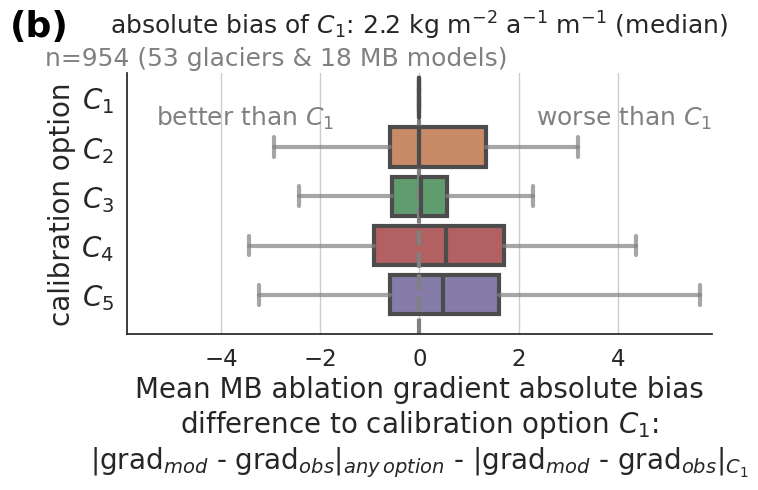

In [37]:
pd_mae_mb_profile_ratio_to_calib_all = pd_mae_mb_profile_ratio_to_calib_all.loc[(pd_mae_mb_profile_ratio_to_calib_all.mb_grad_type != 'mb_pseudo_daily_fake_cte')]
pd_mae_mb_profile_ratio_to_calib_all = pd_mae_mb_profile_ratio_to_calib_all.loc[(pd_mae_mb_profile_ratio_to_calib_all.mb_grad_type != 'mb_pseudo_daily_fake_var_an_cycle')]
pd_mae_mb_profile_ratio_to_calib_all_sel = pd_mae_mb_profile_ratio_to_calib_all  #.loc[pd_mae_mb_profile_ratio_to_calib_all.sfc_type != 'neg_exp\nmonthly_t1yr']

#pd_mae_mb_profile_ratio_to_calib_all_sel = pd_mae_mb_profile_ratio_to_calib_all_sel.loc[pd_mae_mb_profile_ratio_to_calib_all_sel.mb_grad_type != 'mb_pseudo_daily_cte']
#pd_mae_mb_profile_ratio_to_calib_all_sel = pd_mae_mb_profile_ratio_to_calib_all_sel.loc[pd_mae_mb_profile_ratio_to_calib_all_sel.mb_grad_type != 'mb_pseudo_daily_var_an_cycle']

#ds_spread['volume'] = np.abs(ds_spread.volume-1) #ds_spread.volume.
sns.set(font_scale=1.5)
sns.set_style('white')

len_mb_abl_grad_working = len(pd_mb_ablation_grad_match_diff_vs_def_calib_comp.rgi_id.unique())

print(f'n={len_mb_abl_grad_working} glaciers with MB profile\ndata used. '
       +f'for each calib option,\n{3*2*3} TI-model applied')
#ax.text(1.15, 0.3, f'n={len_mb_profile_working} glaciers with MB profile\ndata used. '
#        +f'For each calib option,\n{3*2*3} TI-model options are applied', color = 'grey')


aa = sns.catplot(y='calib_type', x='abs_difference_mod_vs_obs_abl_grad',
                data=pd_mb_ablation_grad_match_diff_vs_def_calib_comp,
                #palette=col_pal_ssp, #
                 kind='box',
                fliersize=0, 
                #col = 'time',
                linewidth=3, #aspect=1.6,
                 height=3.65*3/2,
                aspect=2.5*2/3,
                order = calib_types, #legend_out=False,
                saturation=0.7, #ax=ax,
               whis = [5,95], 
                    capprops={'color':'grey', 'alpha':0.7},
                    whiskerprops={'color':'grey', 'alpha':0.7}
               ) #, grid=True)
#for a,yr in zip(f.axes[0], [2040,2100]):
    #if yr == 2040:
    #    a.set_xlim([0.0,0.1])
    #elif yr==2100:
    #    a.set_xlim([0.45,1.45])
a = aa.axes[0][0]
a.grid(axis='x')

a.text(-0.2, 1.14, f'(b)', color='black', fontsize=26, transform=a.transAxes,weight='bold')
a.text(-0.14, 1.03, f'n={len_mb_abl_grad_working*3*2*3} ({len_mb_abl_grad_working} glaciers & {3*2*3} MB models)', color='grey',
       fontsize=18, transform=a.transAxes)

#a.set_title(yr)
a.set_xlabel(f'Mean MB ablation gradient absolute bias\ndifference to calibration option '+r'$C_1$'+':\n'
             +r'|grad$_{mod}$ - grad$_{obs}$|$_{any\,option}$ - |grad$_{mod}$ - grad$_{obs}$|$_{C_1}$', fontsize=20)


a.set_ylim([4.8, -0.5])
plt.title(#'Mean MB ablation gradient absolute bias comparison:\n'+
          r'absolute bias of $C_1$'+f': {option_a_mb_ablation_grad_match_q[2]:.1f} '+r'kg m$^{-2}$ a$^{-1}$ m$^{-1}$ (median)'+'\n', fontsize=18)

#a.set_xlim([0.2,3.3])

#a.set_xscale("log")

from matplotlib.ticker import ScalarFormatter, NullFormatter
a.xaxis.set_major_formatter(ScalarFormatter())
a.xaxis.set_minor_formatter(NullFormatter())
a.set_xlim([-5.9,5.9])
a.grid()
#a.axes.set_xticklabels([])
#a.set_xticks([0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0]) #, labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
#a.set_yticklabels(['(A)','(B)','(C)','(D)','(E)'])
a.set_yticklabels([f'$C_1$',f'$C_2$',f'$C_3$',f'$C_4$',f'$C_5$'], fontsize=20)

a.set_ylabel('\n'+'calibration option', fontsize=20)

a.text(0.05, 0.8, r'better than $C_1$', color = 'grey', transform=a.transAxes)
a.text(0.7, 0.8, r'worse than $C_1$', color = 'grey', transform=a.transAxes)

plt.grid()

a.axvline(0, ls='--', color = 'grey', lw = 3)

plt.tight_layout()

plt.savefig(f'{fig_path}/fig_3_b_calib_option_performance_mb_profile_only_mb_abl_grad.pdf')
#plt.savefig(f'{fig_path}/calib_option_performance_mb_profile_only_mb_abl_grad.png')

#### only the mae plot for the supplements

/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/local/sw/python/3.10.5/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


n=53 glaciers with MB profile
data used. for each calib option,
18 TI-model applied


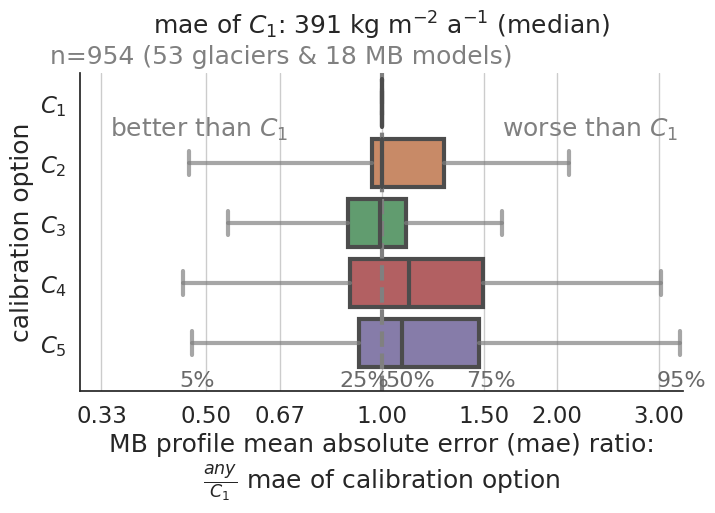

In [38]:
pd_mae_mb_profile_ratio_to_calib_all_sel = pd_mae_mb_profile_ratio_to_calib_all  #.loc[pd_mae_mb_profile_ratio_to_calib_all.sfc_type != 'neg_exp\nmonthly_t1yr']
#pd_mae_mb_profile_ratio_to_calib_all_sel = pd_mae_mb_profile_ratio_to_calib_all_sel.loc[pd_mae_mb_profile_ratio_to_calib_all_sel.mb_grad_type != 'mb_pseudo_daily_cte']
#pd_mae_mb_profile_ratio_to_calib_all_sel = pd_mae_mb_profile_ratio_to_calib_all_sel.loc[pd_mae_mb_profile_ratio_to_calib_all_sel.mb_grad_type != 'mb_pseudo_daily_var_an_cycle']

#ds_spread['volume'] = np.abs(ds_spread.volume-1) #ds_spread.volume.
sns.set(font_scale=1.5)
sns.set_style('white')


len_mb_profile_working = len(pd_mae_mb_profile_ratio_to_calib_all_sel.rgi_id.unique())
print(f'n={len_mb_profile_working} glaciers with MB profile\ndata used. '
       +f'for each calib option,\n{3*2*3} TI-model applied')
#ax.text(1.15, 0.3, f'n={len_mb_profile_working} glaciers with MB profile\ndata used. '
#        +f'For each calib option,\n{3*2*3} TI-model options are applied', color = 'grey')

aa = sns.catplot(y='calib_type', x='mae_mb_profile', data=pd_mae_mb_profile_ratio_to_calib_all_sel,
                #palette=col_pal_ssp, #kind='box',
                fliersize=0,
                kind='box',
                 height=3.65*3/2,
                aspect=2.5*2/3,
                #col = 'time',
                linewidth=3, #aspect=1.6,
                order = calib_types, #legend_out=False,
                saturation=0.7, #ax=ax,
               whis = [5,95], 
                    capprops={'color':'grey', 'alpha':0.7},
                    whiskerprops={'color':'grey', 'alpha':0.7}
               ) #, grid=True)
#for a,yr in zip(f.axes[0], [2040,2100]):
    #if yr == 2040:
    #    a.set_xlim([0.0,0.1])
    #elif yr==2100:
    #    a.set_xlim([0.45,1.45])
a = aa.axes[0][0]
a.grid()

plt.title(#'MB profile mean absolute error (mae) comparison:\n'+
          r'mae of $C_1$'+f': {option_a_mae_mb_profile_q[2]:.0f} '+r'kg m$^{-2}$ a$^{-1}$ (median)'+'\n', fontsize=18)

#a.text(-0.075, 1.08, f'(b)', color='black', fontsize=28, transform=a.transAxes,weight='bold')
#a.text(0.02, 0.93, f'n={len_mb_profile_working} glaciers & {3*2*3} MB models', color='black', fontsize=18, transform=a.transAxes)
a.text(-0.05, 1.03, f'n={len_mb_profile_working*3*2*3} ({len_mb_profile_working} glaciers & {3*2*3} MB models)', color='grey',
       fontsize=18, transform=a.transAxes)
#a.set_title(yr)
a.set_xlabel(r'MB profile mean absolute error (mae) ratio:'+'\n'+
             r'$\frac{any}{C_1}$ mae of calibration option',
             fontsize=18)


qs = pd_mae_mb_profile_ratio_to_calib_all_sel.groupby('calib_type').mae_mb_profile.quantile([0.05,0.25,0.5,0.75,0.95]).loc[('calib_only_geod_temp_b_0_pf_fit_via_winter_mb')].values
#ax.text(qs[0]-14,-0.42,f'percentiles:', color = 'dimgrey', fontsize=15)

for p,q in enumerate(qs):
    perci = [5,25,50,75,95][p]
    if perci == 5:
        a.text(q-0.02,+4.73,f'{perci}%', color = 'dimgrey', fontsize=16)
    elif perci == 95:
        a.text(q-0.3,+4.73,f'{perci}%', color = 'dimgrey', fontsize=16)
    else:
        a.text(q-0.07,+4.73,f'{perci}%', color = 'dimgrey', fontsize=16)
a.set_ylim([4.8, -0.5])
#a.set_xlim([0.2,3.3])

a.set_xscale("log")

from matplotlib.ticker import ScalarFormatter, NullFormatter
a.xaxis.set_major_formatter(ScalarFormatter())
a.xaxis.set_minor_formatter(NullFormatter())
a.set_xlim([0.303,3.3])
#a.axes.set_xticklabels([])
a.set_xticks([0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0]) #, labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
a.set_yticklabels([f'$C_1$',f'$C_2$',f'$C_3$',f'$C_4$',f'$C_5$'])
a.set_ylabel('calibration option')


a.text(0.05, 0.8, f'better than $C_1$', color = 'grey', transform=a.transAxes)
a.text(0.7, 0.8, f'worse than $C_1$', color = 'grey', transform=a.transAxes)

plt.grid(axis='y')

a.axvline(1, ls='--', color = 'grey', lw = 3)

plt.tight_layout()
plt.savefig(f'{fig_path}/figures_supplements/fig_S6_calib_option_performance_mb_profile_suppl_mae.pdf')
#plt.savefig(f'{fig_path}/calib_option_performance_mb_profile.png')


----

### Additional analysis and plots that are not shown in manuscript or supplements:

#### Show temperature-index model performance for all calibration options:
- We don't use this plot as the differences between the calibration options hide the differences between temperature-index options... and we can use only 53 instead of 80 glaciers!
    - i.e. instead we showed above in Fig. 3a only calibration option C5:

[ 0.26112191  1.49982576  3.20793636  5.31376371 12.40074352]
n=53 glaciers with MB abl. gradient 
data used. 


/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/local/sw/python/3.10.5/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/local/sw/python/3.10.5/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Versi

Text(-0.14, 1.15, 'n=53 glaciers & only $C_5$')

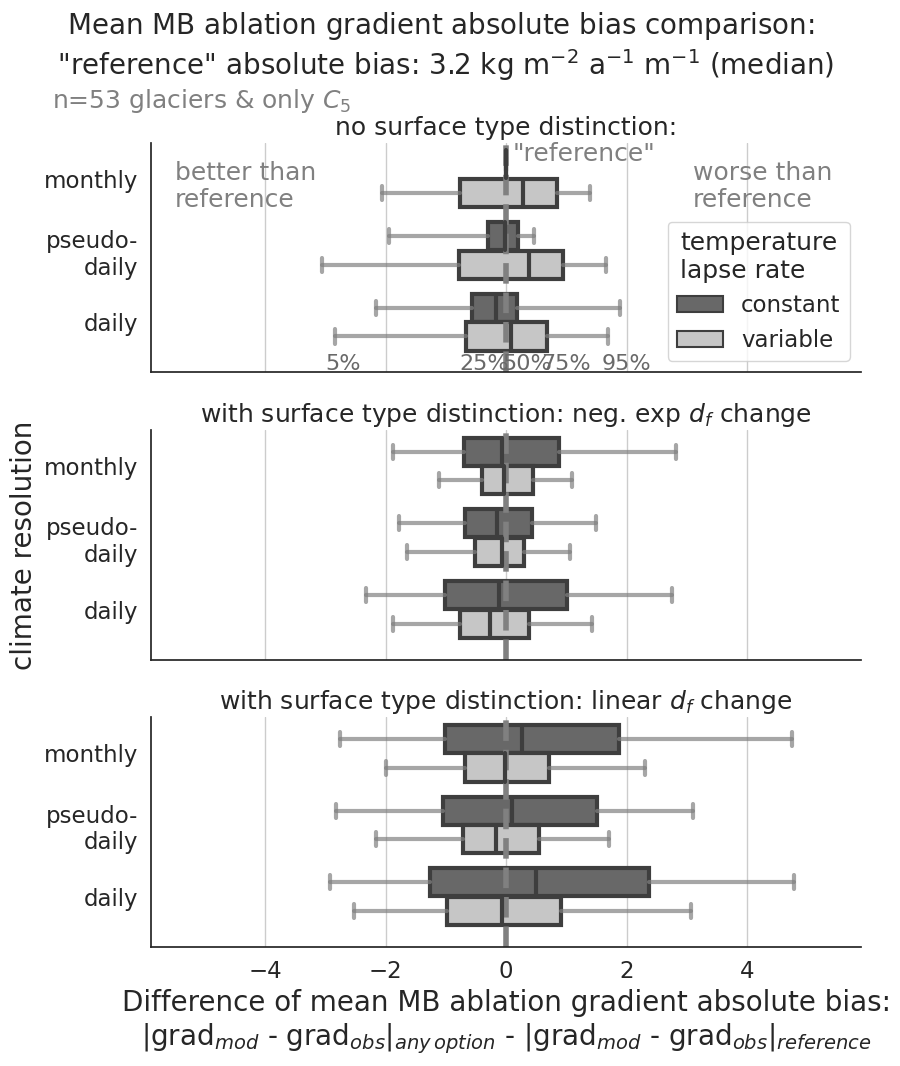

In [39]:
mb_ablation_grad_match_diff_ratio_vs_def_all_calib = xr_params_stats_w_calib_comp_mb_abl_grad[['abs_difference_mod_vs_obs_abl_grad']] - xr_params_stats_w_calib_comp_mb_abl_grad.sel(grad_type=['cte'],
                                                                                                mb_type = ['mb_monthly'], 
                                                                                                sfc_type=['False']).abs_difference_mod_vs_obs_abl_grad.values
pd_mb_ablation_grad_match_diff_ratio_vs_def_all_calib = mb_ablation_grad_match_diff_ratio_vs_def_all_calib.to_dataframe().reset_index().dropna()

default_mb_abl_grad_diff_all_calib = xr_params_stats_w_for_calib_option_e_mb_abl_grad.sel(grad_type=['cte'], mb_type = ['mb_monthly'],
                                                                                          sfc_type=['False']).abs_difference_mod_vs_obs_abl_grad.values.flatten()
default_mb_abl_grad_diff_all_calib = default_mb_abl_grad_diff_all_calib[~np.isnan(default_mb_abl_grad_diff_all_calib)]
default_mb_abl_grad_diff_q_all_calib = np.quantile(default_mb_abl_grad_diff_all_calib, q=[0.025, 0.25,0.5,0.75,0.975])
print(default_mb_abl_grad_diff_q_all_calib)

#pd_std_quot_abs_diff_to_1_vs_def_sel = pd_std_quot_abs_diff_to_1_vs_def_sel.loc[pd_std_quot_abs_diff_to_1_vs_def_sel.mb_type != 'mb_pseudo_daily']
#pd_std_quot_abs_diff_to_1_vs_def_sel = pd_std_quot_abs_diff_to_1_vs_def_sel.loc[pd_std_quot_abs_diff_to_1_vs_def_sel.sfc_type != 'neg_exp\nmonthly_t1yr']

len_mb_abl_grad_working = len(pd_mb_ablation_grad_match_diff_ratio_vs_def_all_calib.rgi_id.unique())

#ds_spread['volume'] = np.abs(ds_spread.volume-1) #ds_spread.volume.
sns.set(font_scale=1.5)
sns.set_style('white')

#plt.figure(figsize=(18,10))
#ax = plt.gca()
#ax.text(1.3, 0.3, f'n={len_mb_profile_working} glaciers with MB profile\ndata used. ')
print(f'n={len_mb_abl_grad_working} glaciers with MB abl. gradient \ndata used. ')
f= sns.catplot(y='mb_type', x='abs_difference_mod_vs_obs_abl_grad',
               hue='grad_type', row='sfc_type', data=pd_mb_ablation_grad_match_diff_ratio_vs_def_all_calib,
                              row_order = ['False', 'neg_exp', 'linear'],
               palette='Greys_r',
               hue_order=['cte', 'var_an_cycle'],
               order=['mb_monthly', 'mb_pseudo_daily_fake', 'mb_real_daily'],
                #palette=col_pal_ssp, #
                kind='box',
                fliersize=0, 
               legend_out=False,
               height=3.65,
                linewidth=3, aspect=2.5,
                #col = 'time',
                #order = calib_types, #legend_out=False,
                saturation=0.7, #ax=ax,
               whis = [5,95], 
                    capprops={'color':'grey', 'alpha':0.7},
                    whiskerprops={'color':'grey', 'alpha':0.7}
               ) #, grid=True)

#f.axes[0][0].text(-0.2, 1.05, f'(b)', color='black', fontsize=24, transform=f.axes[0][0].transAxes)

#plt.suptitle(r'(b)  '+'Comparion of mean absolute MB ablation gradient biases:\n'+f'"default": {default_mb_abl_grad_diff_q[2]:.1f} '+r'kg m$^{-2}$ a$^{-1}$ m$^{-1}$ (median)', fontsize=20)

#f.axes[0][0].text(-0.9, -0.2, f'n={len_std_working} glaciers with\ninterannual variability data used')

ax = plt.gca()
f.axes[0][0].text(0.1, -0.25, f'"reference"', color='gray')
#f.axes[0][0].text(-4.9, 0.63, f'better than reference', color = 'grey')
#f.axes[0][0].text(1.4, 0.63, f'worse than reference', color = 'grey')
f.axes[0][0].text(-5.5, 0.4, f'better than\nreference', color = 'grey')
f.axes[0][0].text(3.1, 0.4, f'worse than\nreference', color = 'grey')

f.axes[0][0].set_yticklabels(['monthly', 'pseudo-\ndaily', 'daily'])
f.axes[0][0].set_ylabel('')
leg = f.axes[0][0].legend()
#leg2 = f.axes[0][0].legend(leg.get_patches()[:2], ['constant', 'variable'], title='temperature lapse rate', loc = 'upper right')
leg.remove()
#f.axes[0][0].add_artist(leg2)
f.axes[0][0].axvline(0, lw=4, ls='--', color = 'grey')

f.axes[0][0].set_title('no surface type distinction:')

f.axes[1][0].set_yticklabels(['monthly', 'pseudo-\ndaily', 'daily'])
f.axes[1][0].set_ylabel('climate resolution', fontsize=20)
f.axes[1][0].axvline(0, lw=4, ls='--', color = 'grey')
f.axes[1][0].set_title(r'with surface type distinction: neg. exp $d_f$ change')


f.axes[0][0].set_xlim([-5.9,5.9])
f.axes[1][0].set_xlim([-5.9,5.9])
f.axes[2][0].set_xlim([-5.9,5.9])


f.axes[1][0].grid(axis='x')
f.axes[0][0].grid(axis='x')
f.axes[2][0].grid(axis='x')
                  
f.axes[2][0].set_yticklabels(['monthly', 'pseudo-\ndaily', 'daily'])
f.axes[2][0].set_ylabel('')
f.axes[2][0].axvline(0, lw=4, ls='--', color = 'grey')
f.axes[2][0].set_title(r'with surface type distinction: linear $d_f$ change')

f.axes[0][0].set_ylim([2.7, -0.5])


f.axes[2][0].set_xlabel(f'Difference of mean MB ablation gradient absolute bias:\n'
                        +r'|grad$_{mod}$ - grad$_{obs}$|$_{any\,option}$ - |grad$_{mod}$ - grad$_{obs}$|$_{reference}$', fontsize=20)


pd_qs_legend = pd_mb_ablation_grad_match_diff_ratio_vs_def_all_calib.loc[(pd_mb_ablation_grad_match_diff_ratio_vs_def_all_calib.sfc_type=='False')
                                                         & (pd_mb_ablation_grad_match_diff_ratio_vs_def_all_calib.grad_type=='var_an_cycle') &
                                      (pd_mb_ablation_grad_match_diff_ratio_vs_def_all_calib.mb_type=='mb_real_daily')]
qs = pd_qs_legend.abs_difference_mod_vs_obs_abl_grad.quantile([0.05,0.25,0.5,0.75,0.95]).values
#ax.text(qs[0]-14,-0.42,f'percentiles:', color = 'dimgrey', fontsize=15)

for p,q in enumerate(qs):
    perci = [5,25,50,75,95][p]
    if perci == 5:
        f.axes[0][0].text(q-0.08,+2.67,f'{perci}%', color = 'dimgrey', fontsize=16)
    elif perci == 50:
        f.axes[0][0].text(q-0.16,+2.67,f'{perci}%', color = 'dimgrey', fontsize=16)
    elif perci == 95:
        f.axes[0][0].text(q-0.12,+2.67,f'{perci}%', color = 'dimgrey', fontsize=16)
    else:
        f.axes[0][0].text(q-0.1,+2.67,f'{perci}%', color = 'dimgrey', fontsize=16)

leg = f.axes[0][0].legend()
leg2 = f.axes[0][0].legend(leg.get_patches()[:2], ['constant', 'variable'], title='temperature\nlapse rate',
                           loc = 'lower right')

#plt.suptitle('Comparison of MB profile mean absolute errors (mae):\n'+f'"default" mae: {default_mae_mb_profile_q[2]:.0f} '+r'kg m$^{-2}$ a$^{-1}$ (median)',
#             fontsize=20)
plt.suptitle(r'$\,$Mean MB ablation gradient absolute bias comparison:'+'\n'
             +r'$\,$'+f' "reference" absolute bias: {default_mb_abl_grad_diff_q[2]:.1f} '+r'kg m$^{-2}$ a$^{-1}$ m$^{-1}$ (median)',
             fontsize=20)

plt.tight_layout()
f.axes[0][0].text(-0.14, 1.15, f'n={len_mb_abl_grad_working} glaciers & only '+r'$C_5$',
                  color='grey', fontsize=18, transform=f.axes[0][0].transAxes)
#f.axes[0][0].text(-0.2, 1.49, f'(a)', color='black', fontsize=26, transform=f.axes[0][0].transAxes,weight='bold')
